# <a id='toc1_'></a>[Preparatory work](#toc0_)

## Please note that,  slight discrepancies in results may occur across different machines or IDEs, even when the random seed is set.

**Table of contents**<a id='toc0_'></a>    
- [Preparatory work](#toc1_)    
- [SGP](#toc2_)    
  - [Model](#toc2_1_)    
  - [Bayesian optimization](#toc2_2_)    
  - [Load the best parameters directly](#toc2_3_)    
    - [If you want to reproduce the results of the paper, please use the following parameters in the parameter file or attachment](#toc2_3_1_)    
  - [Data visualization](#toc2_4_)    
  - [SHAP for SGP](#toc2_5_)    
- [ENA](#toc3_)    
  - [Model](#toc3_1_)    
  - [Load the best parameters directly](#toc3_2_)    
    - [If you want to reproduce the results of the paper, please use the following parameters in the parameter file or attachment](#toc3_2_1_)    
  - [Data visualization](#toc3_3_)    
  - [SHAP for ENA](#toc3_4_)    
- [ASI](#toc4_)    
  - [Model](#toc4_1_)    
  - [Load the best parameters directly](#toc4_2_)    
    - [If you want to reproduce the results of the paper, please use the following parameters in the parameter file or attachment](#toc4_2_1_)    
  - [Data visualization](#toc4_3_)    
  - [SHAP for ASI](#toc4_4_)    
- [GUC](#toc5_)    
  - [Model](#toc5_1_)    
  - [Load the best parameters directly](#toc5_2_)    
    - [If you want to reproduce the results of the paper, please use the following parameters in the parameter file or attachment](#toc5_2_1_)    
  - [Data visualization](#toc5_3_)    
  - [SHAP for GUC](#toc5_4_)    
- [Contribution](#toc6_)    
  - [Make sure that the contribution rates of the four sites have been calculated when running this section](#toc6_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.datasets import make_regression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from numpy import mean
from scipy.stats import linregress
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_absolute_percentage_error

# <a id='toc2_'></a>[SGP](#toc0_)
## <a id='toc2_1_'></a>[Model](#toc0_)

In [11]:
# data reading
data = pd.read_csv('E:/aabc\myDeepTree\data-240321/sgpTP21.csv')
data = data.replace(-9999, float('nan'))
data.iloc[:, 0] = pd.to_numeric(data.iloc[:, 0], errors='coerce')
data = data.dropna()
data.columns = [
     'BS_B', 'BS_G', 'BS_R', 'AE_BG', 'AE_BR', 'AE_GR', 'BBS_B', 'BBS_G', 'BBS_R',
    'BSF_B', 'BSF_G', 'BSF_R', 'g_B', 'g_G', 'g_R', 'SSA_B', 'SSA_G', 'SSA_R', 
    'TR_B', 'TR_G', 'TR_R',  'RH', 'BA_B', 'BA_G', 'BA_R','CCN'
]
data

BS_B       BS_G       BS_R     AE_BG     AE_BR     AE_GR  \
0       43.159378  32.873775  20.416563  2.076402  2.259556  2.411959   
1       41.750015  32.088740  20.824280  2.007528  2.090924  2.160319   
2       42.130474  31.954027  20.211250  2.108808  2.209259  2.292844   
3       41.326084  31.567007  20.493525  2.054719  2.104971  2.146785   
4       40.897648  30.978632  19.532179  2.118737  2.223053  2.309854   
...           ...        ...        ...       ...       ...       ...   
728948   5.385745   4.396246   3.392887  1.548425  1.364981  1.212338   
728949   6.156305   5.041541   3.635393  1.523715  1.583064  1.632448   
728952   6.648797   5.497541   4.352057  1.450262  1.248510  1.080632   
728953   6.622446   5.573394   4.833484  1.315449  0.901117  0.556353   
728955   6.647312   5.526936   4.442405  1.407882  1.184109  0.997907   

           BBS_B     BBS_G     BBS_R     BSF_B  ...     SSA_G     SSA_R  \
0       4.657223  3.972297  3.306433  0.107908  ...  0.929365  0.909551   
1       4.692184  3.994470  2.954104  0.112388  ...  0.928578  0.911376   
2       4.482520  3.843897  3.313872  0.106396  ...  0.929742  0.912281   
3       4.566241  3.934870  2.914941  0.110493  ...  0.928693  0.911936   
4       4.530799  3.660422  3.148163  0.110784  ...  0.935095  0.917695   
...          ...       ...       ...       ...  ...       ...       ...   
728948  0.671493  0.640184  0.514532  0.124680  ...  0.848164  0.849899   
728949  0.936615  0.803642  0.951859  0.152139  ...  0.848593  0.841401   
728952  0.980080  1.053014  1.061275  0.147407  ...  0.844928  0.848537   
728953  0.756845  0.829249  1.159335  0.114285  ...  0.845310  0.841636   
728955  0.677854  0.804148  0.407625  0.101974  ...  0.839086  0.849226   

            TR_B      TR_G      TR_R         RH      BA_B      BA_G      BA_R  \
0       0.724439  0.779187  0.831896  53.825000  3.683812  3.058201  2.394383   
1       0.723776  0.778570  0.831359  54.300000  3.629480  3.010897  2.393225   
2       0.723128  0.777963  0.830829  53.133330  3.530699  2.958819  2.302380   
3       0.722495  0.777367  0.830313  53.533333  3.494263  2.958578  2.341061   
4       0.721881  0.776787  0.829809  51.850002  3.171204  2.679318  2.098852   
...          ...       ...       ...        ...       ...       ...       ...   
728948  0.651316  0.699742  0.753117  17.466667  0.996367  0.838645  0.645862   
728949  0.651155  0.699593  0.752984  17.600000  1.145672  0.959065  0.734431   
728952  0.650630  0.699100  0.752537  17.783333  1.306583  1.071775  0.835994   
728953  0.650436  0.698920  0.752375  17.733334  1.276868  1.079658  0.969621   
728955  0.650053  0.698545  0.752040  17.700000  1.300010  1.120479  0.848979   

               CCN  
0         0.000000  
1         0.000000  
2         0.000000  
3         0.000000  
4         0.000000  
...            ...  
728948  247.710011  
728949  249.111098  
728952  254.526510  
728953  255.458028  
728955  269.001343  

[404990 rows x 26 columns]

In [12]:
def remove_outliers(df):
    # Remove outliers using the 3-sigma rule
    for column in df.columns:
        mean = df[column].mean()
        std = df[column].std()
        cutoff = std * 3
        lower = mean - cutoff
        upper = mean + cutoff
        df = df[(df[column] > lower) & (df[column] < upper)]
    return df

# Apply function to remove outliers
data = remove_outliers(data)
data


BS_B       BS_G       BS_R     AE_BG     AE_BR     AE_GR  \
0       43.159378  32.873775  20.416563  2.076402  2.259556  2.411959   
1       41.750015  32.088740  20.824280  2.007528  2.090924  2.160319   
2       42.130474  31.954027  20.211250  2.108808  2.209259  2.292844   
3       41.326084  31.567007  20.493525  2.054719  2.104971  2.146785   
4       40.897648  30.978632  19.532179  2.118737  2.223053  2.309854   
...           ...        ...        ...       ...       ...       ...   
728948   5.385745   4.396246   3.392887  1.548425  1.364981  1.212338   
728949   6.156305   5.041541   3.635393  1.523715  1.583064  1.632448   
728952   6.648797   5.497541   4.352057  1.450262  1.248510  1.080632   
728953   6.622446   5.573394   4.833484  1.315449  0.901117  0.556353   
728955   6.647312   5.526936   4.442405  1.407882  1.184109  0.997907   

           BBS_B     BBS_G     BBS_R     BSF_B  ...     SSA_G     SSA_R  \
0       4.657223  3.972297  3.306433  0.107908  ...  0.929365  0.909551   
1       4.692184  3.994470  2.954104  0.112388  ...  0.928578  0.911376   
2       4.482520  3.843897  3.313872  0.106396  ...  0.929742  0.912281   
3       4.566241  3.934870  2.914941  0.110493  ...  0.928693  0.911936   
4       4.530799  3.660422  3.148163  0.110784  ...  0.935095  0.917695   
...          ...       ...       ...       ...  ...       ...       ...   
728948  0.671493  0.640184  0.514532  0.124680  ...  0.848164  0.849899   
728949  0.936615  0.803642  0.951859  0.152139  ...  0.848593  0.841401   
728952  0.980080  1.053014  1.061275  0.147407  ...  0.844928  0.848537   
728953  0.756845  0.829249  1.159335  0.114285  ...  0.845310  0.841636   
728955  0.677854  0.804148  0.407625  0.101974  ...  0.839086  0.849226   

            TR_B      TR_G      TR_R         RH      BA_B      BA_G      BA_R  \
0       0.724439  0.779187  0.831896  53.825000  3.683812  3.058201  2.394383   
1       0.723776  0.778570  0.831359  54.300000  3.629480  3.010897  2.393225   
2       0.723128  0.777963  0.830829  53.133330  3.530699  2.958819  2.302380   
3       0.722495  0.777367  0.830313  53.533333  3.494263  2.958578  2.341061   
4       0.721881  0.776787  0.829809  51.850002  3.171204  2.679318  2.098852   
...          ...       ...       ...        ...       ...       ...       ...   
728948  0.651316  0.699742  0.753117  17.466667  0.996367  0.838645  0.645862   
728949  0.651155  0.699593  0.752984  17.600000  1.145672  0.959065  0.734431   
728952  0.650630  0.699100  0.752537  17.783333  1.306583  1.071775  0.835994   
728953  0.650436  0.698920  0.752375  17.733334  1.276868  1.079658  0.969621   
728955  0.650053  0.698545  0.752040  17.700000  1.300010  1.120479  0.848979   

               CCN  
0         0.000000  
1         0.000000  
2         0.000000  
3         0.000000  
4         0.000000  
...            ...  
728948  247.710011  
728949  249.111098  
728952  254.526510  
728953  255.458028  
728955  269.001343  

[330362 rows x 26 columns]

In [13]:
data = data[data['CCN'] >0]
data = data[data['SSA_B']<1]
data = data[data['SSA_G']<1]
data = data[data['SSA_R']<1]
data = data[data['BA_B']>0]
data = data[data['BA_G']>0]
data = data[data['BA_R']>0]
# data = data.loc[0:456806,:]# The first 200,000 groups of data in the sgp
# data = data.sample(n=200000, random_state=2024)
# Prepare features and target variable
X = data.drop('CCN', axis=1)  # Features
y = data['CCN']  # Features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)
data

BS_B       BS_G       BS_R     AE_BG     AE_BR     AE_GR  \
5       36.315190  27.969503  18.052286  1.991714  2.103956  2.197353   
6       34.604317  26.661331  17.208166  1.988988  2.103031  2.197925   
7       33.509308  25.435738  16.426088  2.102668  2.138113  2.167607   
8       33.598194  25.436905  16.117731  2.122524  2.207794  2.278747   
9       34.568165  26.600248  17.783026  1.998512  1.989103  1.981274   
...           ...        ...        ...       ...       ...       ...   
728948   5.385745   4.396246   3.392887  1.548425  1.364981  1.212338   
728949   6.156305   5.041541   3.635393  1.523715  1.583064  1.632448   
728952   6.648797   5.497541   4.352057  1.450262  1.248510  1.080632   
728953   6.622446   5.573394   4.833484  1.315449  0.901117  0.556353   
728955   6.647312   5.526936   4.442405  1.407882  1.184109  0.997907   

           BBS_B     BBS_G     BBS_R     BSF_B  ...     SSA_G     SSA_R  \
5       3.773548  3.464851  2.792726  0.103911  ...  0.940363  0.927178   
6       4.021618  3.626426  2.454104  0.116217  ...  0.940014  0.925638   
7       3.899488  3.452181  2.591593  0.116370  ...  0.937432  0.923040   
8       3.455863  3.155629  2.477978  0.102859  ...  0.924001  0.904566   
9       4.173240  3.263742  2.680168  0.120725  ...  0.920219  0.904761   
...          ...       ...       ...       ...  ...       ...       ...   
728948  0.671493  0.640184  0.514532  0.124680  ...  0.848164  0.849899   
728949  0.936615  0.803642  0.951859  0.152139  ...  0.848593  0.841401   
728952  0.980080  1.053014  1.061275  0.147407  ...  0.844928  0.848537   
728953  0.756845  0.829249  1.159335  0.114285  ...  0.845310  0.841636   
728955  0.677854  0.804148  0.407625  0.101974  ...  0.839086  0.849226   

            TR_B      TR_G      TR_R         RH      BA_B      BA_G      BA_R  \
5       0.707051  0.762839  0.817633  52.383335  2.683741  2.244908  1.734303   
6       0.706824  0.762624  0.817446  51.391666  2.557827  2.150215  1.683969   
7       0.706382  0.762212  0.817086  51.825000  2.588222  2.127653  1.657185   
8       0.705890  0.761756  0.816688  51.091667  3.012022  2.518159  1.981802   
9       0.705331  0.761233  0.816221  52.550000  3.302551  2.745786  2.179066   
...          ...       ...       ...        ...       ...       ...       ...   
728948  0.651316  0.699742  0.753117  17.466667  0.996367  0.838645  0.645862   
728949  0.651155  0.699593  0.752984  17.600000  1.145672  0.959065  0.734431   
728952  0.650630  0.699100  0.752537  17.783333  1.306583  1.071775  0.835994   
728953  0.650436  0.698920  0.752375  17.733334  1.276868  1.079658  0.969621   
728955  0.650053  0.698545  0.752040  17.700000  1.300010  1.120479  0.848979   

               CCN  
5       798.650658  
6       912.411032  
7       844.085035  
8       863.700829  
9       881.721786  
...            ...  
728948  247.710011  
728949  249.111098  
728952  254.526510  
728953  255.458028  
728955  269.001343  

[322981 rows x 26 columns]

## <a id='toc2_2_'></a>[Bayesian optimization](#toc0_)

In [ ]:


xgb_params = {
    'n_estimators': Integer(50, 1000),
    'max_depth': Integer(3, 16),
    'learning_rate': Real(0.01, 0.4, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'random_state': Categorical([2024]),  
    # 'tree_method': Categorical(['gpu_hist']) 
}



rf_params = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 16),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 6),
    'random_state': Categorical([2024])  
}


cb_params = {
    'iterations': Integer(50, 1000),
    'depth': Integer(3, 16),
    'learning_rate': Real(0.01, 0.4, prior='log-uniform'),
    'l2_leaf_reg': Real(0.05, 10, prior='log-uniform'),
    'random_state': Categorical([2024]),  
    # 'task_type': Categorical(['GPU']), 
    # 'devices': Categorical(['0:1']),
    'train_dir': Categorical(["./catboost_info"])  
}


opt_xgb = BayesSearchCV(XGBRegressor(), xgb_params, n_iter=10, cv=5, n_jobs=-1, verbose=10)
opt_rf = BayesSearchCV(RandomForestRegressor(), rf_params, n_iter=10, cv=5, n_jobs=-1, verbose=10)
opt_cb = BayesSearchCV(CatBoostRegressor(verbose=0), cb_params, n_iter=10, cv=5, n_jobs=-1, verbose=10)

opt_xgb.fit(X_train, y_train)
opt_rf.fit(X_train, y_train)
opt_cb.fit(X_train, y_train)

print("Best XGBoost params:", opt_xgb.best_params_)
print("Best RF params:", opt_rf.best_params_)
print("Best CatBoost params:", opt_cb.best_params_)


In [ ]:
from sklearn.ensemble import VotingRegressor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Plot Bayesian optimization process
def plot_optimization_results(opt, model_name):
    results = opt.cv_results_
    best_scores = -np.array(results['mean_test_score'])
    plt.plot(best_scores, marker='o', label=f'{model_name} Best Score')
    plt.xlabel('Iteration')
    plt.ylabel('Neg Mean Test Score')
    plt.title(f'{model_name} Optimization')
    plt.legend()

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plot_optimization_results(opt_xgb, "XGBoost")
plt.subplot(1, 3, 2)
plot_optimization_results(opt_rf, "Random Forest")
plt.subplot(1, 3, 3)
plot_optimization_results(opt_cb, "CatBoost")
plt.tight_layout()
plt.show()

# Create models with best parameters
xgb_best = XGBRegressor(**opt_xgb.best_params_, n_jobs=-1)
rf_best = RandomForestRegressor(**opt_rf.best_params_, n_jobs=-1)
cb_best = CatBoostRegressor(**opt_cb.best_params_, verbose=0)

# Create ensemble model
ensemble_model = VotingRegressor(estimators=[
    ('xgb', xgb_best),
    ('rf', rf_best),
    ('cb', cb_best)
])

# Train ensemble model
ensemble_model.fit(X_train, y_train)

# Make predictions
predictions = ensemble_model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')


## <a id='toc2_3_'></a>[Load the best parameters directly](#toc0_)
### <a id='toc2_3_1_'></a>[If you want to reproduce the results of the paper, please use the following parameters in the parameter file or attachment](#toc0_)

In [ ]:
# If you want to reproduce the work of the paper, please use the following parameter file or use the attached parameters
opt_xgb_best_params = np.load('E:/aabc/myDeepTree/data-240520/sgpxgb.npy', allow_pickle=True).item()
opt_rf_best_params = np.load('E:/aabc/myDeepTree/data-240520/sgprf.npy', allow_pickle=True).item()
opt_cb_best_params = np.load('E:/aabc/myDeepTree/data-240520/sgpcb.npy', allow_pickle=True).item()
print(opt_xgb_best_params,opt_rf_best_params,opt_cb_best_params)

In [ ]:
# Use optimal parameters
xgb_best = XGBRegressor(**opt_xgb_best_params, n_jobs=-1)
rf_best = RandomForestRegressor(**opt_rf_best_params, n_jobs=-1)
# xgb_best = XGBRegressor(**opt_xgb_best_params)
# rf_best = RandomForestRegressor(**opt_rf_best_params)
cb_best = CatBoostRegressor(**opt_cb_best_params, verbose=0)

# Create an integration model
ensemble_model = VotingRegressor(estimators=[
    ('xgb', xgb_best),
    ('rf', rf_best),
    ('cb', cb_best)
])

ensemble_model.fit(X_train, y_train)

predictions = ensemble_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')


## <a id='toc2_4_'></a>[Data visualization](#toc0_)

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


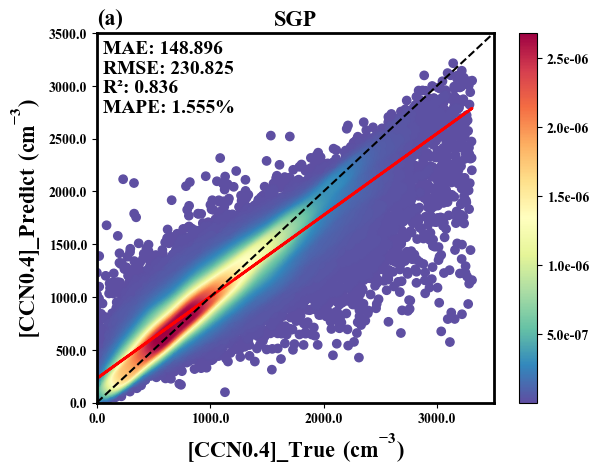

In [ ]:

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'


def density_scatter(x, y, ax=None, is_cbar=False, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    ax.scatter(x, y, c=z, cmap='Spectral_r')

    if is_cbar:
        norm = Normalize(vmin=np.min(z), vmax=np.max(z))
        cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap='Spectral_r'), ax=ax)
        cbar.ax.tick_params(labelsize=10)  
        cbar.ax.set_yticklabels(['{:.1e}'.format(t) for t in cbar.get_ticks()], fontname='Times New Roman') 

    return ax


x = y_test.to_numpy()
y = predictions

fig = plt.figure()
ax = fig.add_subplot(111)

ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

density_scatter(x=x, y=y, ax=ax, is_cbar=True)

slope, intercept, r_value, p_value, std_err = linregress(x, y)

regression_line = slope * x + intercept
plt.plot(x, regression_line, 'red', lw=2, label='线性回归线')

plt.plot([0, 3500], [0, 3500], 'black', lw=1.5, linestyle='--')  # 1:1
plt.axis([0, 3500, 0, 3500])

ax.tick_params(axis='both', labelsize=14)

ax.set_xticklabels(ax.get_xticks(), size=14)
ax.set_yticklabels(ax.get_yticks(), size=14)

BIAS_sgp = mean(x - y)
MSE_sgp = mean_squared_error(x, y)
RMSE_sgp = np.power(MSE_sgp, 0.5)
R2_sgp = r2_score(x, y)
MAE_sgp = mean_absolute_error(x, y)
EV_sgp = explained_variance_score(x, y)
MAPE_sgp = mean_absolute_percentage_error(x, y)
# text = f'\nMAE: {MAE:.3f}\nRMSE: {RMSE:.3f}\nR²: {R2:.3f}\nMAPE: {MAPE:.3f}%'
text = f'\nMAE: {MAE_sgp:.3f}\nRMSE: {RMSE_sgp:.3f}\nR²: {R2_sgp:.3f}\nMAPE: {MAPE_sgp:.3f}%'
plt.yticks(fontsize=10, fontname='Times New Roman', fontweight='bold')
plt.xticks(fontsize=10, fontname='Times New Roman', fontweight='bold')
plt.xlabel(r'[CCN0.4]_True$\mathregular{\ (cm^{-3})}$', fontsize=16, fontname='Times New Roman', fontweight='bold')
plt.ylabel(r'[CCN0.4]_Predict$\mathregular{\ (cm^{-3})}$', fontsize=16, fontname='Times New Roman', fontweight='bold')
plt.title('(a)', loc='left', fontsize=16, fontname='Times New Roman', fontweight='bold')
plt.title('SGP', fontsize=16, fontname='Times New Roman', fontweight='bold')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.text(50,2750, text, fontsize=14, fontname='Times New Roman')
# plt.savefig('E:/aabc/summary/fig-240804/sgp.png',dpi=300,bbox_inches='tight',pad_inches=0)

plt.show()


## <a id='toc2_5_'></a>[SHAP for SGP](#toc0_)

In [ ]:
# SHAP interactions are based on the xgboost model
xgb_model = XGBRegressor(**opt_xgb.best_params_, n_jobs=-1)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

In [ ]:
# Randomly select 3000 samples for SHAP analysis
np.random.seed(2024)
indices = np.random.choice(X_test.shape[0], 3000, replace=False)
# selected_X_test = X_test  # Comment this out if using the random subset
selected_X_test = X_test.iloc[indices]
# Create an explainer
explainer = shap.TreeExplainer(xgb_model)
# Compute SHAP interaction values
shap_interaction_values = explainer.shap_interaction_values(selected_X_test)


In [ ]:
# shap
explainer = shap.KernelExplainer(ensemble_model.predict, data=X_train.sample(100))
shap_values = explainer.shap_values(X_test.iloc[indices])


X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  0%|          | 0/3000 [00:00<?, ?it/s]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  0%|          | 1/3000 [00:08<7:03:18,  8.47s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  0%|          | 2/3000 [00:16<6:45:14,  8.11s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  0%|          | 3/3000 [00:23<6:27:59,  7.77s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was

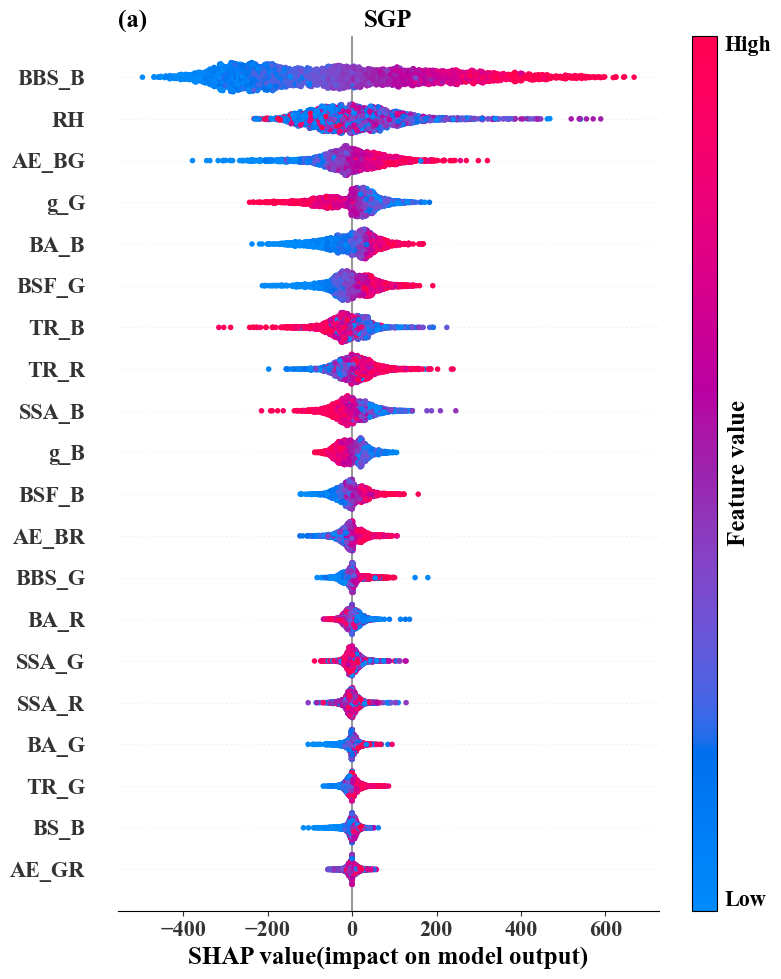

In [ ]:
# summary
import os
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'

shap.summary_plot(shap_values, selected_X_test, show=False,color_bar=False)
cbar = plt.colorbar(aspect=35)
cbar.set_label('Feature value',size=18,fontname='Times New Roman', fontweight='bold')
cbar.ax.set_yticklabels([])
cbar.ax.tick_params(axis='y', which='both', length=0)
cbar.ax.text(1.3,0,'Low',va='bottom',ha='left',transform=cbar.ax.transAxes,fontsize=16)
cbar.ax.text(1.3,1,'High',va='top',ha='left',transform=cbar.ax.transAxes,fontsize=16)

plt.xlabel('SHAP value(impact on model output)',fontsize=18,fontname='Times New Roman', fontweight='bold')
plt.tick_params(axis='x',labelsize=16)
plt.tick_params(axis='y',labelsize=16)
plt.title('(a)', loc='left', fontsize=18, fontname='Times New Roman', fontweight='bold')
plt.title('SGP', fontsize=18, fontname='Times New Roman', fontweight='bold')
# plt.savefig('E:/aabc/summary/fig-240804/shap-sgp.png',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()


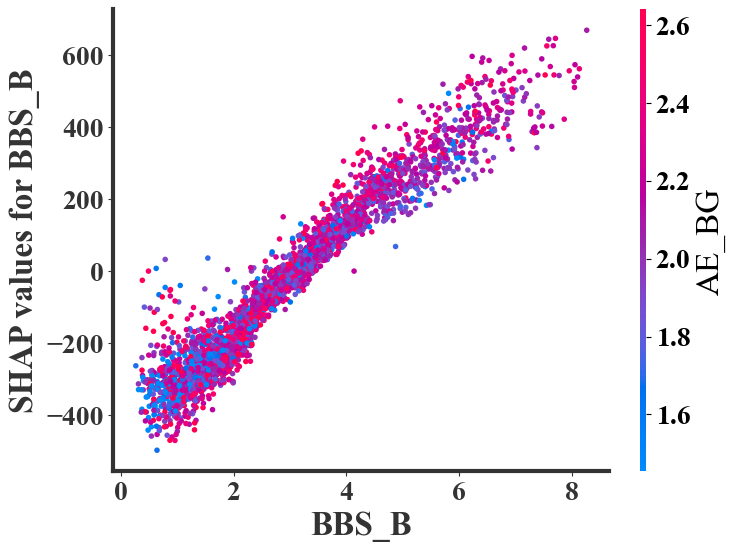

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
shap.dependence_plot('BBS_B', shap_values, selected_X_test, interaction_index='AE_BG', ax=ax, show=False)
# dependence

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20) # 设置标签字体大小
cbar.set_label('AE_BG', fontsize=24) # 设置标签大小
ax.set_xlabel('BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# plt.savefig('E:/aabc/summary/fig-240804/sgp11.png',dpi=300,bbox_inches='tight',pad_inches=0)

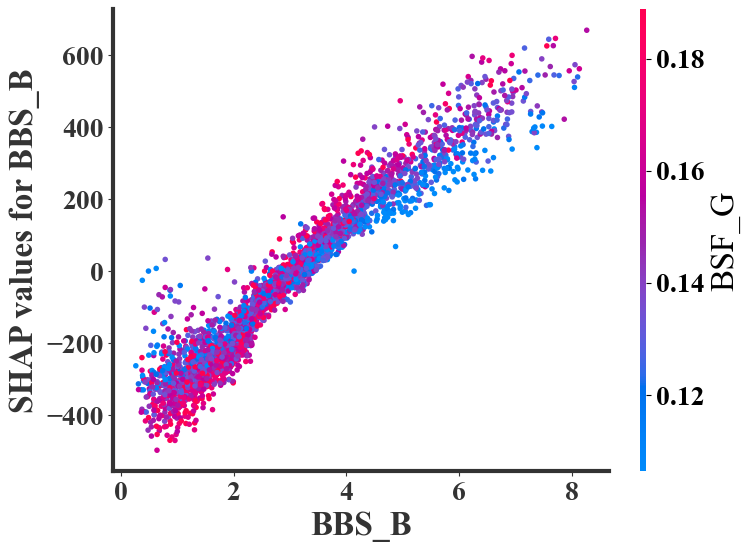

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
shap.dependence_plot('BBS_B', shap_values, selected_X_test, interaction_index='BSF_G', ax=ax, show=False)
# dependence

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20) # 设置标签字体大小
cbar.set_label('BSF_G', fontsize=24) # 设置标签大小
ax.set_xlabel('BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# plt.savefig('E:/aabc/summary/fig-240804/sgp1.png',dpi=300,bbox_inches='tight',pad_inches=0)

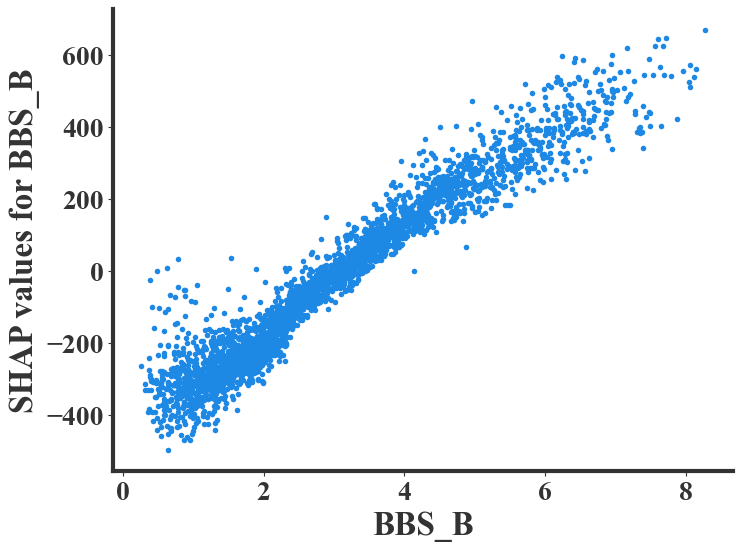

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
shap.dependence_plot('BBS_B', shap_values, selected_X_test, interaction_index=None, ax=ax, show=False)
# dependence

# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=20) # 设置标签字体大小
# cbar.set_label('AE_BG', fontsize=24) # 设置标签大小
ax.set_xlabel('BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# plt.savefig('E:/aabc/summary/fig-240804/sgp2.png',dpi=300,bbox_inches='tight',pad_inches=0)

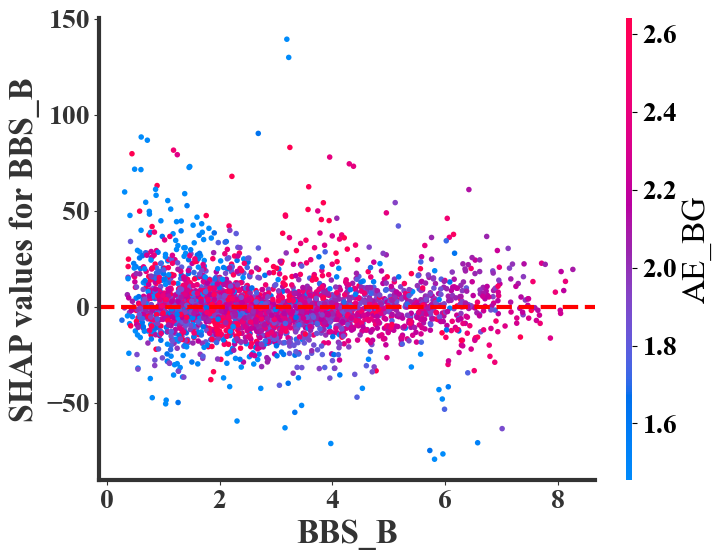

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
# interaction
shap.dependence_plot(
    "BBS_B",  # key feature
    shap_interaction_values[:, :, selected_X_test.columns.get_loc("AE_BG")],  
    selected_X_test,
    interaction_index="AE_BG",  # interactive feature
    ax=ax,
    show=False
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20) # 设置标签字体大小
cbar.set_label('AE_BG', fontsize=24) # 设置标签大小
ax.set_xlabel('BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# ax.set_title('(b)', loc='left', fontsize=20, fontname='Times New Roman', fontweight='bold')
ax.axhline(0, color='red', linestyle='--', linewidth=3)
# plt.savefig('E:/aabc/summary/fig-240804/sgp33.png',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()


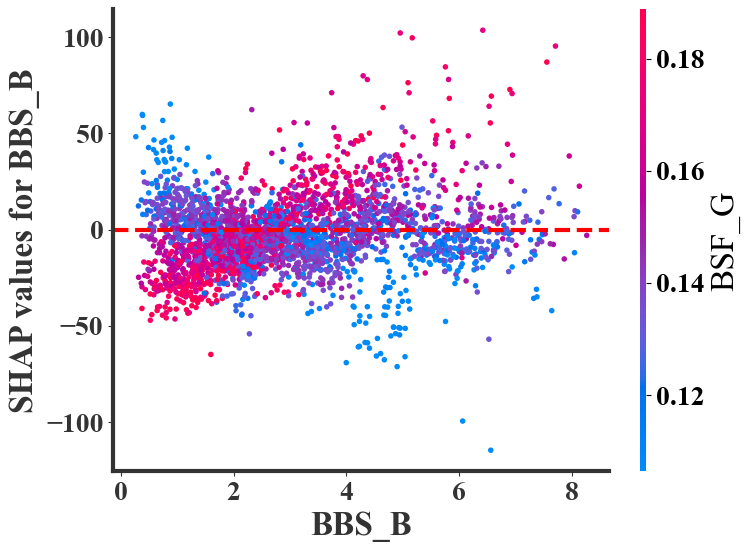

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
# interaction
shap.dependence_plot(
    "BBS_B",  # key feature
    shap_interaction_values[:, :, selected_X_test.columns.get_loc("BSF_G")],  
    selected_X_test,
    interaction_index="BSF_G",  # interactive feature
    ax=ax,
    show=False
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20) # 设置标签字体大小
cbar.set_label('BSF_G', fontsize=24) # 设置标签大小
ax.set_xlabel('BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# ax.set_title('(e)', loc='left', fontsize=20, fontname='Times New Roman', fontweight='bold')
ax.axhline(0, color='red', linestyle='--', linewidth=3)
# plt.savefig('E:/aabc/summary/fig-240804/sgp3.png',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()


In [ ]:
# save
shap_values_df = pd.DataFrame(shap_values, columns=X_train.columns)

shap_values_df
# shap_values_df.to_csv('E:/aabc\myDeepTree\data-240801/sgpshap_values.csv', index=False)

feature_importance = np.abs(shap_values_df).mean().sort_values(ascending=False)
# feature_importance.to_csv('E:/aabc\myDeepTree\data-240801/sgpfeature_importance.csv')
total_shap = feature_importance.sum()

# contribution_ratio
feature_contribution_ratio = (feature_importance / total_shap) * 100

# feature_contribution_ratio.to_csv('E:/aabc\myDeepTree\data-240801/sgpfeature_contribution_ratio.csv')


# <a id='toc3_'></a>[ENA](#toc0_)
## <a id='toc3_1_'></a>[Model](#toc0_)

In [14]:
# data reading
data_ena = pd.read_csv('E:/aabc\myDeepTree\data-240321/enaTP.csv')
data_ena = data_ena.replace(-9999, float('nan'))
data_ena.iloc[:, 0] = pd.to_numeric(data_ena.iloc[:, 0], errors='coerce')
data_ena = data_ena.dropna()
data_ena.columns = [
    'CCN', 'BS_B', 'BS_G', 'BS_R', 'AE_BG', 'AE_BR', 'AE_GR', 'BBS_B', 'BBS_G', 'BBS_R',
    'BSF_B', 'BSF_G', 'BSF_R', 'g_B', 'g_G', 'g_R', 'SSA_B', 'SSA_G', 'SSA_R', 
    'TR_B', 'TR_G', 'TR_R',  'RH', 'BA_B', 'BA_G', 'BA_R'
]
data_ena

CCN        BS_B       BS_G       BS_R     AE_BG     AE_BR  \
6       188.570519   12.201920  11.268949  10.160663  0.606712  0.541549   
9       188.551949    5.785304   4.496477   2.463578  1.922344  2.626811   
10      192.804885    5.078589   4.006073   2.120290  1.809419  2.705262   
11      184.134383    5.349239   4.219896   1.978972  1.808824  3.107762   
12      175.663232    5.378540   3.941111   2.279664  2.371816  2.592139   
...            ...         ...        ...        ...       ...       ...   
884337  966.239065  106.520520  89.762890  60.273376  1.305574  1.749552   
884338  961.047592  107.140780  90.267960  59.916790  1.307063  1.788464   
884339  963.115913  107.720436  89.633255  60.089863  1.402041  1.786205   
884340  964.778060  107.578190  90.251850  59.643880  1.339503  1.813596   
884341  960.182517  107.151726  90.246220  60.885420  1.309678  1.735130   

           AE_GR      BBS_B     BBS_G     BBS_R  ...     SSA_B     SSA_G  \
6       0.487326   1.555767  1.884566  2.258289  ...  0.981434  0.982776   
9       3.212996   0.949426  0.743746  0.820735  ...  0.981967  0.974161   
10      3.450691   0.792668  0.703125  0.462293  ...  0.984197  0.974434   
11      4.188606   0.321848  0.081604  0.268721  ...  0.979688  0.977434   
12      2.775469   0.718397  0.601325  0.668369  ...  0.980835  0.973219   
...          ...        ...       ...       ...  ...       ...       ...   
884337  2.118985  10.163909  8.939054  8.071537  ...  0.964444  0.962887   
884338  2.189038  10.055898  8.909332  8.229902  ...  0.964974  0.963340   
884339  2.105867  10.443869  8.614413  8.270635  ...  0.965561  0.963255   
884340  2.208089  10.380535  8.890059  8.665967  ...  0.965481  0.963540   
884341  2.089148  10.249699  9.078943  8.402697  ...  0.965959  0.964152   

           SSA_R      TR_B      TR_G      TR_R         RH      BA_B      BA_G  \
6       0.990027  0.834811  0.855457  0.879395  56.208332  0.370999  0.345914   
9       0.970859  0.834714  0.855361  0.879296  56.033333  0.205075  0.198055   
10      0.949172  0.834690  0.855335  0.879275  55.816666  0.167970  0.175317   
11      0.954087  0.834670  0.855316  0.879260  55.750000  0.202162  0.171599   
12      0.955878  0.834643  0.855291  0.879240  55.700000  0.197908  0.177702   
...          ...       ...       ...       ...        ...       ...       ...   
884337  0.952837  0.788660  0.811584  0.841764  53.875000  5.712098  4.995297   
884338  0.952240  0.788020  0.810998  0.841258  53.875000  5.683852  4.979607   
884339  0.951966  0.787386  0.810417  0.840751  53.900000  5.649621  4.953185   
884340  0.952497  0.786750  0.809835  0.840252  53.916668  5.648754  4.959206   
884341  0.952272  0.786204  0.809331  0.839809  54.050000  5.569840  4.896980   

            BA_R  
6       0.237489  
9       0.118139  
10      0.152363  
11      0.131667  
12      0.146475  
...          ...  
884337  4.044834  
884338  4.061180  
884339  4.090518  
884340  4.025472  
884341  4.122853  

[683059 rows x 26 columns]

In [15]:
def remove_outliers(df):
    # Remove outliers using the 3-sigma rule
    for column in df.columns:
        mean = df[column].mean()
        std = df[column].std()
        cutoff = std * 3
        lower = mean - cutoff
        upper = mean + cutoff
        df = df[(df[column] > lower) & (df[column] < upper)]
    return df

# Apply function to remove outliers
data_ena = remove_outliers(data_ena)
data_ena


CCN       BS_B       BS_G       BS_R     AE_BG     AE_BR  \
6       188.570519  12.201920  11.268949  10.160663  0.606712  0.541549   
10      192.804885   5.078589   4.006073   2.120290  1.809419  2.705262   
12      175.663232   5.378540   3.941111   2.279664  2.371816  2.592139   
13      182.135887   4.617376   3.719979   2.543268  1.648376  1.800863   
14      189.717088   4.981643   3.936539   2.525809  1.795965  2.060050   
...            ...        ...        ...        ...       ...       ...   
881943  527.073848  35.876736  28.738312  20.026070  1.692230  1.751611   
881968  524.666357  34.861960  28.206255  20.362028  1.615914  1.609254   
881989  592.978897  27.580744  21.472673  13.045682  1.909453  2.278582   
881991  572.935669  26.647186  21.258610  12.825631  1.723225  2.241411   
882010  667.212437  28.302176  22.718086  13.279922  1.676360  2.331360   

           AE_GR     BBS_B     BBS_G     BBS_R  ...     SSA_B     SSA_G  \
6       0.487326  1.555767  1.884566  2.258289  ...  0.981434  0.982776   
10      3.450691  0.792668  0.703125  0.462293  ...  0.984197  0.974434   
12      2.775469  0.718397  0.601325  0.668369  ...  0.980835  0.973219   
13      1.927746  0.806420  0.568288  0.399561  ...  0.981202  0.975082   
14      2.279795  0.105942  0.355360  0.264591  ...  0.985124  0.975558   
...          ...       ...       ...       ...  ...       ...       ...   
881943  1.801022  3.576501  3.499958  3.341776  ...  0.969452  0.965660   
881968  1.603713  3.668443  3.311346  3.349562  ...  0.972035  0.968592   
881989  2.585734  2.569013  2.255573  2.396343  ...  0.958757  0.952543   
881991  2.672593  2.625459  2.252750  2.056174  ...  0.959416  0.953635   
882010  2.876385  3.198739  2.219345  2.266968  ...  0.960166  0.954873   

           SSA_R      TR_B      TR_G      TR_R         RH      BA_B      BA_G  \
6       0.990027  0.834811  0.855457  0.879395  56.208332  0.370999  0.345914   
10      0.949172  0.834690  0.855335  0.879275  55.816666  0.167970  0.175317   
12      0.955878  0.834643  0.855291  0.879240  55.700000  0.197908  0.177702   
13      0.945963  0.834622  0.855271  0.879218  55.516666  0.167017  0.159441   
14      0.955459  0.834605  0.855253  0.879197  55.500000  0.159984  0.166997   
...          ...       ...       ...       ...        ...       ...       ...   
881943  0.962408  0.792250  0.812105  0.837142  53.616665  1.723327  1.510914   
881968  0.966596  0.997526  0.997744  0.998039  54.500000  1.618409  1.424886   
881989  0.937317  0.990886  0.991901  0.993212  52.483334  1.698597  1.477261   
881991  0.936465  0.990357  0.991442  0.992811  52.725000  1.619558  1.435476   
882010  0.938017  0.983390  0.985327  0.987765  52.391666  1.694193  1.501174   

            BA_R  
6       0.237489  
10      0.152363  
12      0.146475  
13      0.191103  
14      0.163124  
...          ...  
881943  1.130054  
881968  1.076585  
881989  1.129832  
881991  1.123681  
882010  1.138947  

[506413 rows x 26 columns]

In [16]:
data_ena = data_ena[data_ena['CCN'] >0]
data_ena = data_ena[data_ena['AE_BG'] >0]
data_ena = data_ena[data_ena['AE_BR'] >0]
data_ena = data_ena[data_ena['AE_GR'] >0]
data_ena = data_ena[data_ena['BA_B'] >0]
data_ena = data_ena[data_ena['BA_G'] >0]
data_ena = data_ena[data_ena['BA_R'] >0]
data_ena = data_ena[data_ena['SSA_B'] <1]
data_ena = data_ena[data_ena['SSA_G'] <1]
data_ena = data_ena[data_ena['SSA_R'] <1]
# data = data.loc[0:456806,:]# The first 200,000 groups of data in the sgp
# data_ena = data_ena.sample(n=200000, random_state=2024)
# Prepare features and target variable
X_ena = data_ena.drop('CCN', axis=1)  # Features
y_ena = data_ena['CCN']  # Features
X_train_ena, X_test_ena, y_train_ena, y_test_ena = train_test_split(X_ena, y_ena, test_size=0.2, random_state=2024)

In [ ]:
# Define parameter search space
xgb_params_ena = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(3, 16),
    'learning_rate': Real(0.01, 0.4, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0)
}

rf_params_ena = {
    'n_estimators': Integer(100, 900),
    'max_depth': Integer(3, 16),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 6)
}
# CatBoost parameter space
cb_params_ena = {
    'iterations': Integer(50, 500),
    'depth': Integer(3, 16),
    'learning_rate': Real(0.01, 0.4, prior='log-uniform'),
    'l2_leaf_reg': Real(0.05, 10, prior='log-uniform'),
    'train_dir': Categorical(["./catboost_info"])  # Use the catboost_info folder in the current directory
}

# Create Bayesian optimization objects
opt_xgb_ena = BayesSearchCV(XGBRegressor(), xgb_params_ena, n_iter=20, cv=5, n_jobs=-1, verbose=10)
opt_rf_ena = BayesSearchCV(RandomForestRegressor(), rf_params_ena, n_iter=20, cv=5, n_jobs=-1, verbose=10)
opt_cb_ena = BayesSearchCV(CatBoostRegressor(verbose=0), cb_params_ena, n_iter=20, cv=5, n_jobs=-1, verbose=10)

# Execute search
opt_xgb_ena.fit(X_train_ena, y_train_ena)
opt_rf_ena.fit(X_train_ena, y_train_ena)
opt_cb_ena.fit(X_train_ena, y_train_ena)

# Get best parameters
print("Best XGBoost params:", opt_xgb_ena.best_params_)
print("Best RF params:", opt_rf_ena.best_params_)
print("Best CatBoost params:", opt_cb_ena.best_params_)


In [ ]:
from sklearn.ensemble import VotingRegressor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Plot Bayesian optimization process
def plot_optimization_results(opt, model_name):
    results = opt.cv_results_
    best_scores = -np.array(results['mean_test_score'])
    plt.plot(best_scores, marker='o', label=f'{model_name} Best Score')
    plt.xlabel('Iteration')
    plt.ylabel('Neg Mean Test Score')
    plt.title(f'{model_name} Optimization')
    plt.legend()

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plot_optimization_results(opt_xgb_ena, "XGBoost")
plt.subplot(1, 3, 2)
plot_optimization_results(opt_rf_ena, "Random Forest")
plt.subplot(1, 3, 3)
plot_optimization_results(opt_cb_ena, "CatBoost")
plt.tight_layout()
plt.show()

# Create models with best parameters
xgb_best_ena_bo = XGBRegressor(**opt_xgb_ena.best_params_, n_jobs=-1)
rf_best_ena_bo = RandomForestRegressor(**opt_rf_ena.best_params_, n_jobs=-1)
cb_best_ena_bo = CatBoostRegressor(**opt_cb_ena.best_params_, verbose=0)

# Create ensemble model
ensemble_model_ena_bo = VotingRegressor(estimators=[
    ('xgb', xgb_best_ena_bo),
    ('rf', rf_best_ena_bo),
    ('cb', cb_best_ena_bo)
])

# Train ensemble model
ensemble_model_ena_bo.fit(X_train_ena, y_train_ena)

# Make predictions
predictions_ena_bo = ensemble_model_ena_bo.predict(X_test_ena)

# Evaluate model
mse_ena_bo = mean_squared_error(y_test_ena, predictions_ena_bo)
print(f'Mean Squared Error: {mse_ena_bo}')


## <a id='toc3_2_'></a>[Load the best parameters directly](#toc0_)
### <a id='toc3_2_1_'></a>[If you want to reproduce the results of the paper, please use the following parameters in the parameter file or attachment](#toc0_)

In [ ]:
# If you want to reproduce the work of the paper, please use the following parameter file or use the attached parameters
opt_xgb_best_params_ena = np.load('E:/aabc/myDeepTree/data-240520/enaxgb.npy', allow_pickle=True).item()
opt_rf_best_params_ena = np.load('E:/aabc/myDeepTree/data-240520/enarf.npy', allow_pickle=True).item()
opt_cb_best_params_ena = np.load('E:/aabc/myDeepTree/data-240520/enacb.npy', allow_pickle=True).item()
print(opt_xgb_best_params_ena,opt_rf_best_params_ena,opt_cb_best_params_ena)

In [ ]:
# Use optimal parameters
xgb_best_ena = XGBRegressor(**opt_xgb_best_params_ena, n_jobs=-1)
rf_best_ena = RandomForestRegressor(**opt_rf_best_params_ena, n_jobs=-1)
# xgb_best = XGBRegressor(**opt_xgb_best_params)
# rf_best = RandomForestRegressor(**opt_rf_best_params)
cb_best_ena = CatBoostRegressor(**opt_cb_best_params_ena, verbose=0)

# Create an integration model
ensemble_model_ena = VotingRegressor(estimators=[
    ('xgb', xgb_best_ena),
    ('rf', rf_best_ena),
    ('cb', cb_best_ena)
])

ensemble_model_ena.fit(X_train_ena, y_train_ena)

predictions_ena = ensemble_model_ena.predict(X_test_ena)
mse_ena = mean_squared_error(y_test_ena, predictions_ena)
print(f'Mean Squared Error: {mse_ena}')


## <a id='toc3_3_'></a>[Data visualization](#toc0_)

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


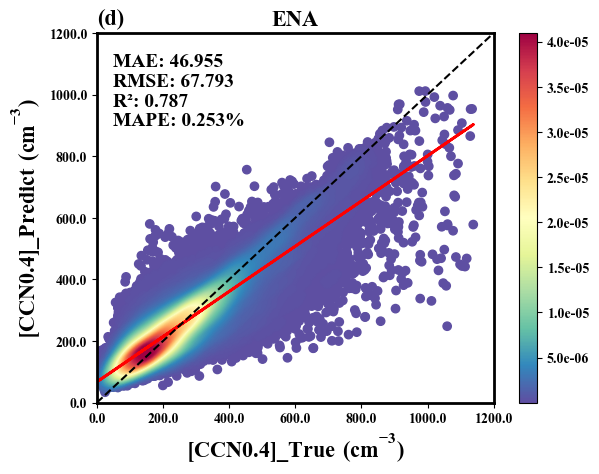

In [ ]:

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'


def density_scatter(x, y, ax=None, is_cbar=False, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    ax.scatter(x, y, c=z, cmap='Spectral_r')

    if is_cbar:
        norm = Normalize(vmin=np.min(z), vmax=np.max(z))
        cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap='Spectral_r'), ax=ax)
        cbar.ax.tick_params(labelsize=10)  
        cbar.ax.set_yticklabels(['{:.1e}'.format(t) for t in cbar.get_ticks()], fontname='Times New Roman') 

    return ax


x = y_test_ena.to_numpy()
y = predictions_ena

fig = plt.figure()
ax = fig.add_subplot(111)

ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

density_scatter(x=x, y=y, ax=ax, is_cbar=True)

slope, intercept, r_value, p_value, std_err = linregress(x, y)

regression_line = slope * x + intercept
plt.plot(x, regression_line, 'red', lw=2, label='线性回归线')

plt.plot([0, 1200], [0, 1200], 'black', lw=1.5, linestyle='--')  # 1:1
plt.axis([0, 1200, 0, 1200])

ax.tick_params(axis='both', labelsize=14)

ax.set_xticklabels(ax.get_xticks(), size=14)
ax.set_yticklabels(ax.get_yticks(), size=14)

BIAS = mean(x - y)
MSE = mean_squared_error(x, y)
RMSE = np.power(MSE, 0.5)
R2 = r2_score(x, y)
MAE = mean_absolute_error(x, y)
EV = explained_variance_score(x, y)
MAPE = mean_absolute_percentage_error(x, y)
text = f'\nMAE: {MAE:.3f}\nRMSE: {RMSE:.3f}\nR²: {R2:.3f}\nMAPE: {MAPE:.3f}%'
plt.yticks(fontsize=10, fontname='Times New Roman', fontweight='bold')
plt.xticks(fontsize=10, fontname='Times New Roman', fontweight='bold')
plt.xlabel(r'[CCN0.4]_True$\mathregular{\ (cm^{-3})}$', fontsize=16, fontname='Times New Roman', fontweight='bold')
plt.ylabel(r'[CCN0.4]_Predict$\mathregular{\ (cm^{-3})}$', fontsize=16, fontname='Times New Roman', fontweight='bold')
plt.title('(d)', loc='left', fontsize=16, fontname='Times New Roman', fontweight='bold')
plt.title('ENA', fontsize=16, fontname='Times New Roman', fontweight='bold')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.text(50,900, text, fontsize=14, fontname='Times New Roman')
# plt.savefig('E:/aabc/summary/fig-240804/ena.png',dpi=300,bbox_inches='tight',pad_inches=0)

plt.show()


## <a id='toc3_4_'></a>[SHAP for ENA](#toc0_)

In [ ]:
# SHAP interactions are based on the xgboost model
xgb_model_ena = XGBRegressor(**opt_xgb_best_params_ena, n_jobs=-1)
xgb_model_ena.fit(X_train_ena, y_train_ena)
xgb_predictions_ena = xgb_model_ena.predict(X_test_ena)

In [18]:
# Randomly select 3000 samples for SHAP analysis
np.random.seed(2024)
indices_ena = np.random.choice(X_test_ena.shape[0], 3000, replace=False)
selected_X_test_ena = X_test_ena.iloc[indices_ena]
# selected_X_test_ena = X_test_ena  # Comment this out if using the random subset
# Create an explainer
explainer = shap.TreeExplainer(xgb_model_ena)
# Compute SHAP interaction values
shap_interaction_values_ena = explainer.shap_interaction_values(selected_X_test_ena)


In [ ]:
# shap
explainer = shap.KernelExplainer(ensemble_model_ena.predict, data=X_train_ena.sample(100))
shap_values_ena = explainer.shap_values(X_test_ena.iloc[indices_ena])


X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  0%|          | 0/3000 [00:00<?, ?it/s]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  0%|          | 1/3000 [00:04<3:51:40,  4.64s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  0%|          | 2/3000 [00:08<3:41:01,  4.42s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  0%|          | 3/3000 [00:13<3:39:45,  4.40s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was

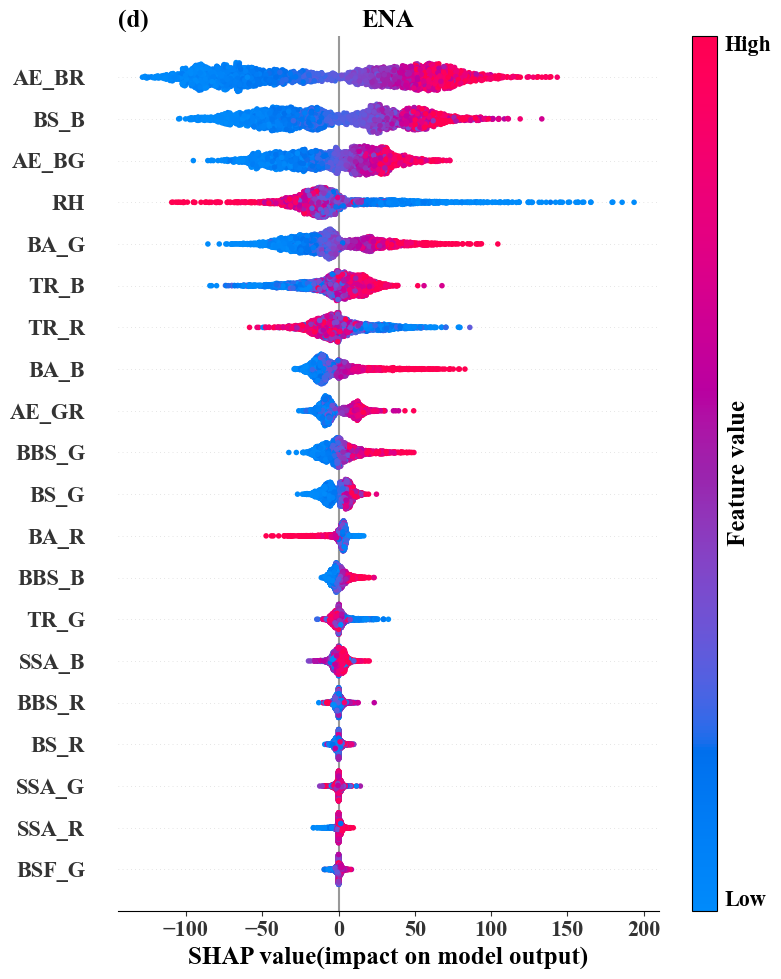

In [ ]:
# summary
import os
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'

shap.summary_plot(shap_values_ena, selected_X_test_ena, show=False,color_bar=False)
cbar = plt.colorbar(aspect=35)
cbar.set_label('Feature value',size=18,fontname='Times New Roman', fontweight='bold')
cbar.ax.set_yticklabels([])
cbar.ax.tick_params(axis='y', which='both', length=0)
cbar.ax.text(1.3,0,'Low',va='bottom',ha='left',transform=cbar.ax.transAxes,fontsize=16)
cbar.ax.text(1.3,1,'High',va='top',ha='left',transform=cbar.ax.transAxes,fontsize=16)

plt.xlabel('SHAP value(impact on model output)',fontsize=18,fontname='Times New Roman', fontweight='bold')
plt.tick_params(axis='x',labelsize=16)
plt.tick_params(axis='y',labelsize=16)
plt.title('(d)', loc='left', fontsize=18, fontname='Times New Roman', fontweight='bold')
plt.title('ENA', fontsize=18, fontname='Times New Roman', fontweight='bold')
# plt.savefig('E:/aabc/summary/fig-240804/shap-ena.png',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()


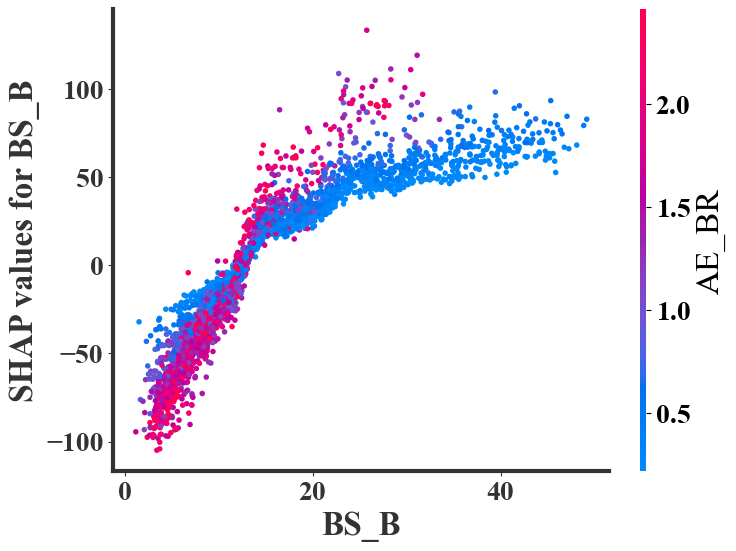

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
# dependence
shap.dependence_plot('BS_B', shap_values_ena, selected_X_test_ena, interaction_index='AE_BR', ax=ax, show=False)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.set_label('AE_BR', fontsize=24) 
ax.set_xlabel('BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# plt.savefig('E:/aabc/summary/fig-240804/ena1.png',dpi=300,bbox_inches='tight',pad_inches=0)

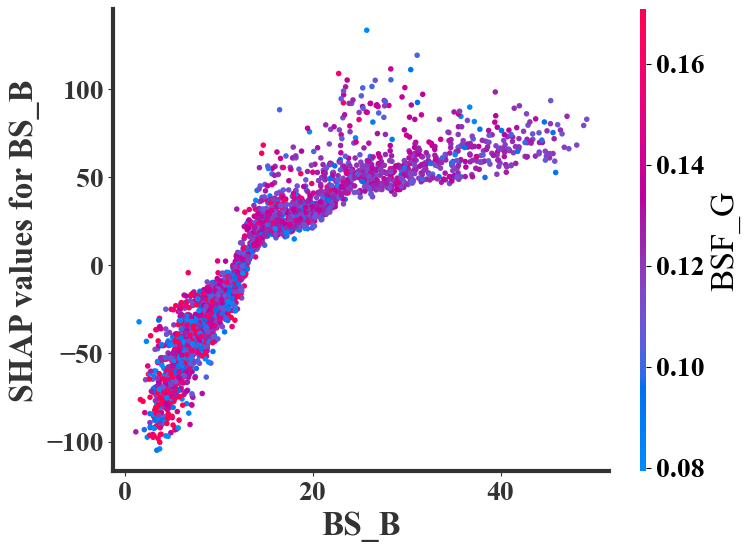

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

# dependence
shap.dependence_plot('BS_B', shap_values_ena, selected_X_test_ena, interaction_index='BSF_G', ax=ax, show=False)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20) 
cbar.set_label('BSF_G', fontsize=24) 
ax.set_xlabel('BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# plt.savefig('E:/aabc/summary/fig-240804/ena11.png',dpi=300,bbox_inches='tight',pad_inches=0)

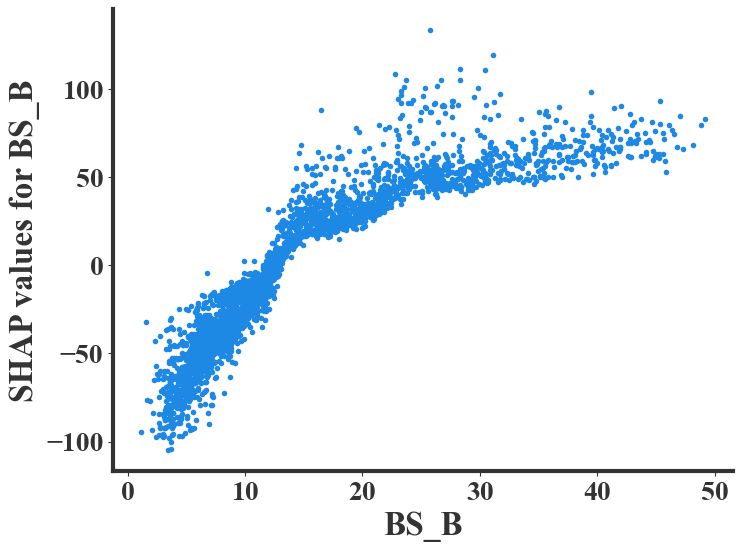

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

# dependence
shap.dependence_plot('BS_B', shap_values_ena, selected_X_test_ena, interaction_index=None, ax=ax, show=False)
# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=20) 
# cbar.set_label('BSF_G', fontsize=24) 
ax.set_xlabel('BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# plt.savefig('E:/aabc/summary/fig-240804/ena2.png',dpi=300,bbox_inches='tight',pad_inches=0)

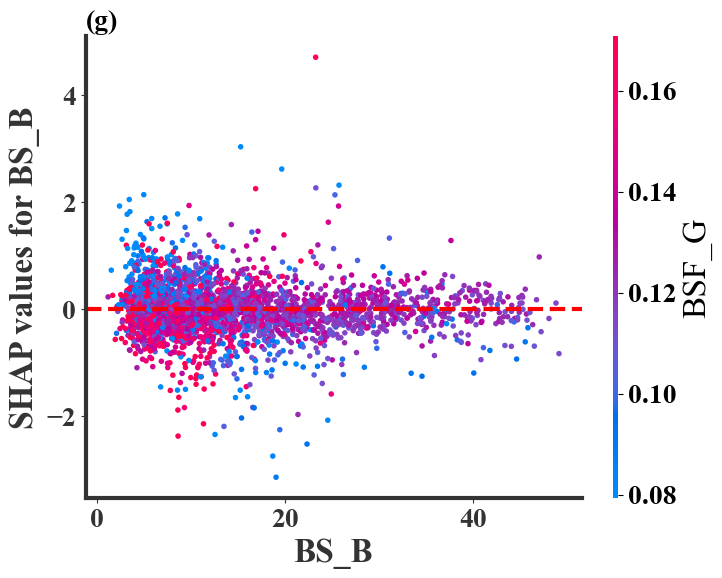

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
# interaction
shap.dependence_plot(
    "BS_B",  # key feature
    shap_interaction_values_ena[:, :, selected_X_test_ena.columns.get_loc("BSF_G")],  
    selected_X_test_ena,
    interaction_index="BSF_G",  # interactive feature
    ax=ax,
    show=False
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20) 
cbar.set_label('BSF_G', fontsize=24)
ax.set_xlabel('BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_title('(g)', loc='left', fontsize=20, fontname='Times New Roman', fontweight='bold')
ax.axhline(0, color='red', linestyle='--', linewidth=3)
# plt.savefig('E:/aabc/summary/fig-240804/ena33t.png',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()


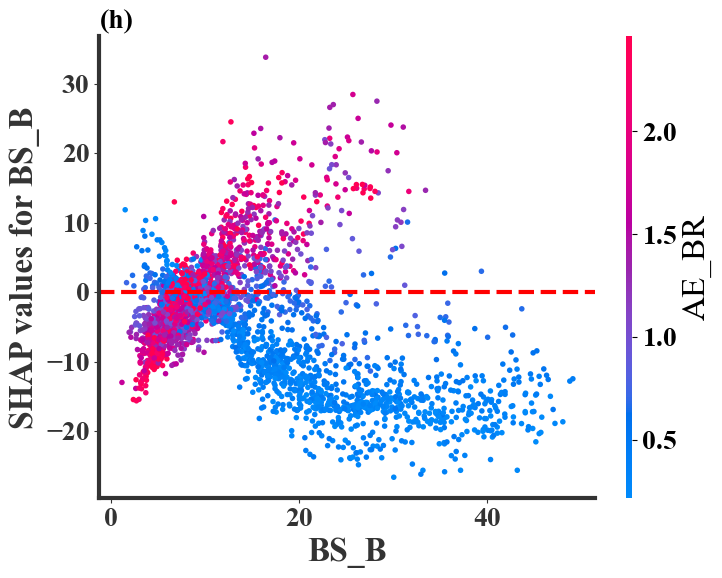

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
# interaction
shap.dependence_plot(
    "BS_B",  # key feature
    shap_interaction_values_ena[:, :, selected_X_test_ena.columns.get_loc("AE_BR")],  
    selected_X_test_ena,
    interaction_index="AE_BR",  # interactive feature
    ax=ax,
    show=False
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20) 
cbar.set_label('AE_BR', fontsize=24) 
ax.set_xlabel('BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_title('(h)', loc='left', fontsize=20, fontname='Times New Roman', fontweight='bold')
ax.axhline(0, color='red', linestyle='--', linewidth=3)
# plt.savefig('E:/aabc/summary/fig-240804/ena3t.png',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()


In [ ]:
# save
shap_values_df_ena = pd.DataFrame(shap_values_ena, columns=X_train_ena.columns)

shap_values_df_ena
# shap_values_df_ena.to_csv('E:/aabc\myDeepTree\data-240801/enashap_values.csv', index=False)

feature_importance_ena = np.abs(shap_values_df_ena).mean().sort_values(ascending=False)
# feature_importance_ena.to_csv('E:/aabc\myDeepTree\data-240801/enafeature_importance.csv')
total_shap_ena = feature_importance_ena.sum()

# contribution_ratio
feature_contribution_ratio_ena = (feature_importance_ena / total_shap_ena) * 100

# feature_contribution_ratio_ena.to_csv('E:/aabc\myDeepTree\data-240801/enafeature_contribution_ratio.csv')
feature_contribution_ratio_ena

# <a id='toc4_'></a>[ASI](#toc0_)
## <a id='toc4_1_'></a>[Model](#toc0_)

In [29]:
# data reading
data_asi = pd.read_csv('E:/aabc\myDeepTree\data-240321/asiTP.csv')
data_asi = data_asi.replace(-9999, float('nan'))
data_asi.iloc[:, 0] = pd.to_numeric(data_asi.iloc[:, 0], errors='coerce')
data_asi = data_asi.dropna()
data_asi.columns = [
    'CCN', 'BS_B', 'BS_G', 'BS_R', 'AE_BG', 'AE_BR', 'AE_GR', 'BBS_B', 'BBS_G', 'BBS_R',
    'BSF_B', 'BSF_G', 'BSF_R', 'g_B', 'g_G', 'g_R', 'SSA_B', 'SSA_G', 'SSA_R', 
    'TR_B', 'TR_G', 'TR_R',  'RH', 'BA_B', 'BA_G', 'BA_R'
]
data_asi

CCN       BS_B       BS_G       BS_R     AE_BG     AE_BR  \
0       101.253667  22.481018  21.559175  19.866217  0.319365  0.375890   
1        99.866000  23.375761  22.696941  20.890125  0.224779  0.349093   
2        96.089167  21.505592  21.363607  18.998453  0.050527  0.406966   
3        96.167167  19.118690  18.185902  16.474014  0.381528  0.452928   
4        95.601167  15.857728  14.828381  13.630428  0.511916  0.446571   
...            ...        ...        ...        ...       ...       ...   
485048    0.373828   8.431938   6.773862   3.999436  1.670089  2.296070   
485049    0.567981   8.952989   6.936341   4.172319  1.946648  2.323871   
485050    0.485132   8.518941   6.414651   3.706067  2.163990  2.528604   
485051    0.350301   7.881830   6.565426   4.074286  1.393877  2.040656   
485052    0.328821   8.180118   6.749057   4.006367  1.466805  2.212110   

           AE_GR     BBS_B     BBS_G     BBS_R  ...     SSA_B     SSA_G  \
0       0.422925  3.462915  3.190206  3.167963  ...  1.009189  1.013580   
1       0.452534  3.506959  3.079141  3.168227  ...  0.978253  0.981265   
2       0.703559  2.714427  2.553211  2.777568  ...  0.950047  0.953130   
3       0.512339  2.464471  2.417343  2.337645  ...  0.944280  0.942133   
4       0.392197  1.381179  1.378797  1.677934  ...  0.974986  0.975753   
...          ...       ...       ...       ...  ...       ...       ...   
485048  2.816948  1.126593  1.193067  0.927468  ...  0.844806  0.841283   
485049  2.637758  1.054484  0.794995  0.509370  ...  0.859341  0.851866   
485050  2.831999  0.485955  0.739108  0.929532  ...  0.849920  0.839433   
485051  2.578840  0.680449  0.940279  0.706358  ...  0.842907  0.843351   
485052  2.832278  0.609692  0.911705  0.679426  ...  0.850808  0.848455   

           SSA_R      TR_B      TR_G      TR_R         RH      BA_B      BA_G  \
0       1.016958  0.971529  0.969593  0.966454  64.583336  0.162558  0.050938   
1       0.983799  0.971444  0.969522  0.966401  67.191666  0.923225  0.826057   
2       0.949358  0.971260  0.969354  0.966250  69.525000  1.520157  1.438961   
3       0.938591  0.971025  0.969126  0.966026  69.550000  1.479760  1.454632   
4       0.976643  0.970855  0.968962  0.965878  67.841670  0.683579  0.628171   
...          ...       ...       ...       ...        ...       ...       ...   
485048  0.794991  0.999703  0.999751  0.999814  55.400000  1.746308  1.439267   
485049  0.816160  0.999431  0.999528  0.999638  55.550000  1.669551  1.367980   
485050  0.790281  0.999156  0.999304  0.999466  55.600000  1.702796  1.380826   
485051  0.815168  0.998889  0.999086  0.999301  55.600000  1.653102  1.374429   
485052  0.808047  0.998619  0.998858  0.999126  55.446156  1.622552  1.363328   

            BA_R  
0      -0.015398  
1       0.707971  
2       1.365382  
3       1.388140  
4       0.566406  
...          ...  
485048  1.137069  
485049  1.045255  
485050  1.082406  
485051  1.026733  
485052  1.054611  

[485053 rows x 26 columns]

In [30]:
def remove_outliers(df):
    # Remove outliers using the 3-sigma rule
    for column in df.columns:
        mean = df[column].mean()
        std = df[column].std()
        cutoff = std * 3
        lower = mean - cutoff
        upper = mean + cutoff
        df = df[(df[column] > lower) & (df[column] < upper)]
    return df

# Apply function to remove outliers
data_asi = remove_outliers(data_asi)
data_asi


CCN       BS_B       BS_G       BS_R     AE_BG     AE_BR  \
0       101.253667  22.481018  21.559175  19.866217  0.319365  0.375890   
1        99.866000  23.375761  22.696941  20.890125  0.224779  0.349093   
2        96.089167  21.505592  21.363607  18.998453  0.050527  0.406966   
3        96.167167  19.118690  18.185902  16.474014  0.381528  0.452928   
4        95.601167  15.857728  14.828381  13.630428  0.511916  0.446571   
...            ...        ...        ...        ...       ...       ...   
485048    0.373828   8.431938   6.773862   3.999436  1.670089  2.296070   
485049    0.567981   8.952989   6.936341   4.172319  1.946648  2.323871   
485050    0.485132   8.518941   6.414651   3.706067  2.163990  2.528604   
485051    0.350301   7.881830   6.565426   4.074286  1.393877  2.040656   
485052    0.328821   8.180118   6.749057   4.006367  1.466805  2.212110   

           AE_GR     BBS_B     BBS_G     BBS_R  ...     SSA_B     SSA_G  \
0       0.422925  3.462915  3.190206  3.167963  ...  1.009189  1.013580   
1       0.452534  3.506959  3.079141  3.168227  ...  0.978253  0.981265   
2       0.703559  2.714427  2.553211  2.777568  ...  0.950047  0.953130   
3       0.512339  2.464471  2.417343  2.337645  ...  0.944280  0.942133   
4       0.392197  1.381179  1.378797  1.677934  ...  0.974986  0.975753   
...          ...       ...       ...       ...  ...       ...       ...   
485048  2.816948  1.126593  1.193067  0.927468  ...  0.844806  0.841283   
485049  2.637758  1.054484  0.794995  0.509370  ...  0.859341  0.851866   
485050  2.831999  0.485955  0.739108  0.929532  ...  0.849920  0.839433   
485051  2.578840  0.680449  0.940279  0.706358  ...  0.842907  0.843351   
485052  2.832278  0.609692  0.911705  0.679426  ...  0.850808  0.848455   

           SSA_R      TR_B      TR_G      TR_R         RH      BA_B      BA_G  \
0       1.016958  0.971529  0.969593  0.966454  64.583336  0.162558  0.050938   
1       0.983799  0.971444  0.969522  0.966401  67.191666  0.923225  0.826057   
2       0.949358  0.971260  0.969354  0.966250  69.525000  1.520157  1.438961   
3       0.938591  0.971025  0.969126  0.966026  69.550000  1.479760  1.454632   
4       0.976643  0.970855  0.968962  0.965878  67.841670  0.683579  0.628171   
...          ...       ...       ...       ...        ...       ...       ...   
485048  0.794991  0.999703  0.999751  0.999814  55.400000  1.746308  1.439267   
485049  0.816160  0.999431  0.999528  0.999638  55.550000  1.669551  1.367980   
485050  0.790281  0.999156  0.999304  0.999466  55.600000  1.702796  1.380826   
485051  0.815168  0.998889  0.999086  0.999301  55.600000  1.653102  1.374429   
485052  0.808047  0.998619  0.998858  0.999126  55.446156  1.622552  1.363328   

            BA_R  
0      -0.015398  
1       0.707971  
2       1.365382  
3       1.388140  
4       0.566406  
...          ...  
485048  1.137069  
485049  1.045255  
485050  1.082406  
485051  1.026733  
485052  1.054611  

[376458 rows x 26 columns]

In [31]:
data_asi = data_asi[data_asi['CCN'] >0]
data_asi = data_asi[data_asi['AE_BG'] >0]
data_asi = data_asi[data_asi['AE_BR'] >0]
data_asi = data_asi[data_asi['AE_GR'] >0]
data_asi = data_asi[data_asi['BA_B'] >0]
data_asi = data_asi[data_asi['BA_G'] >0]
data_asi = data_asi[data_asi['BA_R'] >0]
data_asi = data_asi[data_asi['SSA_B'] <1]
data_asi = data_asi[data_asi['SSA_G'] <1]
data_asi = data_asi[data_asi['SSA_R'] <1]
# data = data.loc[0:456806,:]# The first 200,000 groups of data in the sgp
# data_asi = data_asi.sample(n=200000, random_state=2024)
# Prepare features and target variable
X_asi = data_asi.drop('CCN', axis=1)  # Features
y_asi = data_asi['CCN']  # Features
X_train_asi, X_test_asi, y_train_asi, y_test_asi = train_test_split(X_asi, y_asi, test_size=0.2, random_state=2024)

In [ ]:
# Define parameter search space
xgb_params_asi = {
    'n_estimators': Integer(50, 600),
    'max_depth': Integer(3, 16),
    'learning_rate': Real(0.01, 0.4, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0)
}

rf_params_asi = {
    'n_estimators': Integer(100, 900),
    'max_depth': Integer(3, 16),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 6)
}
# CatBoost parameter space
cb_params_asi = {
    'iterations': Integer(50, 600),
    'depth': Integer(3, 16),
    'learning_rate': Real(0.01, 0.4, prior='log-uniform'),
    'l2_leaf_reg': Real(0.05, 10, prior='log-uniform'),
    'train_dir': Categorical(["./catboost_info"])  # Use the catboost_info folder in the current directory
}

# Create Bayesian optimization objects
opt_xgb_asi = BayesSearchCV(XGBRegressor(), xgb_params_asi, n_iter=20, cv=5, n_jobs=-1, verbose=10)
opt_rf_asi = BayesSearchCV(RandomForestRegressor(), rf_params_asi, n_iter=20, cv=5, n_jobs=-1, verbose=10)
opt_cb_asi = BayesSearchCV(CatBoostRegressor(verbose=0), cb_params_asi, n_iter=20, cv=5, n_jobs=-1, verbose=10)

# Execute search
opt_xgb_asi.fit(X_train_asi, y_train_asi)
opt_rf_asi.fit(X_train_asi, y_train_asi)
opt_cb_asi.fit(X_train_asi, y_train_asi)

# Get best parameters
print("Best XGBoost params:", opt_xgb_asi.best_params_)
print("Best RF params:", opt_rf_asi.best_params_)
print("Best CatBoost params:", opt_cb_asi.best_params_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

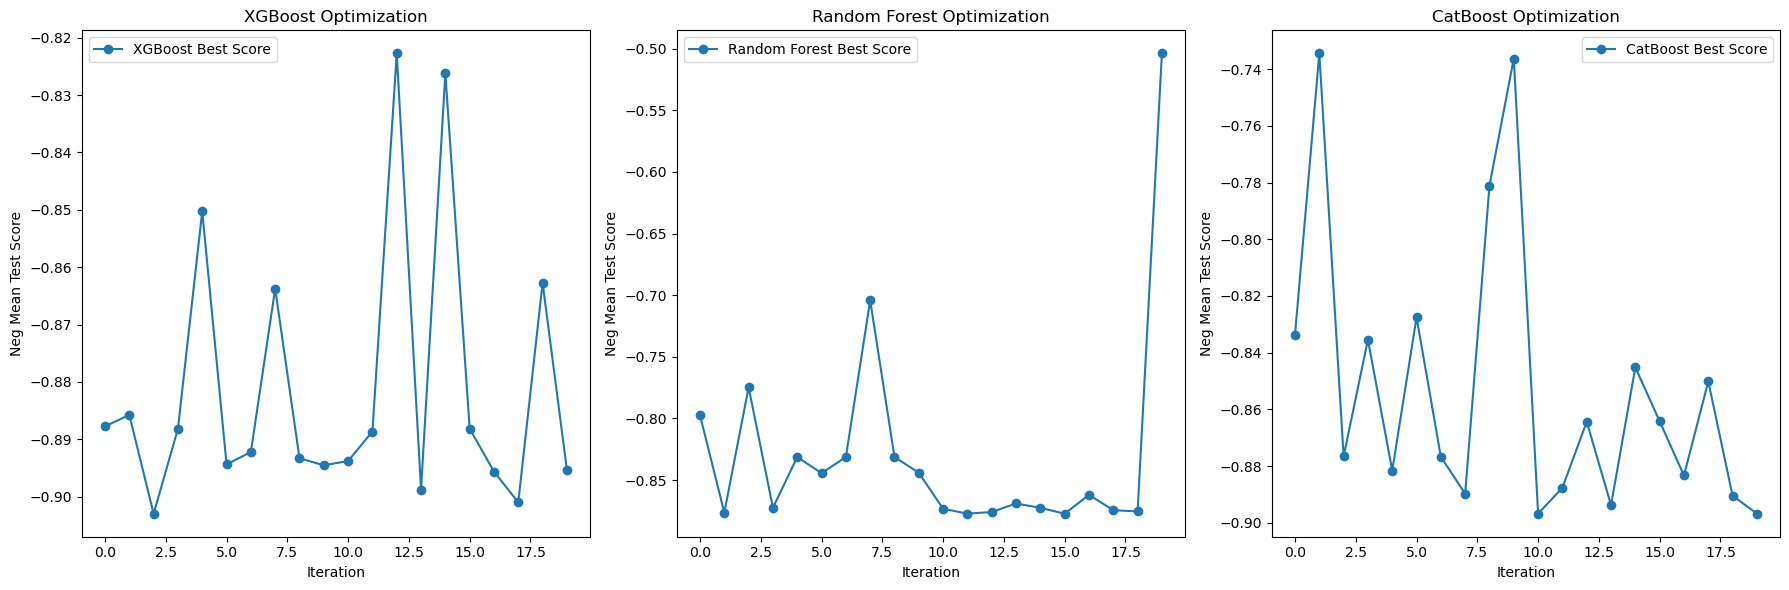

Mean Squared Error: 1082.5548129316835


In [ ]:
from sklearn.ensemble import VotingRegressor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Plot Bayesian optimization process
def plot_optimization_results(opt, model_name):
    results = opt.cv_results_
    best_scores = -np.array(results['mean_test_score'])
    plt.plot(best_scores, marker='o', label=f'{model_name} Best Score')
    plt.xlabel('Iteration')
    plt.ylabel('Neg Mean Test Score')
    plt.title(f'{model_name} Optimization')
    plt.legend()

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plot_optimization_results(opt_xgb_asi, "XGBoost")
plt.subplot(1, 3, 2)
plot_optimization_results(opt_rf_asi, "Random Forest")
plt.subplot(1, 3, 3)
plot_optimization_results(opt_cb_asi, "CatBoost")
plt.tight_layout()
plt.show()

# Create models with best parameters
xgb_best_asi = XGBRegressor(**opt_xgb_asi.best_params_, n_jobs=-1)
rf_best_asi = RandomForestRegressor(**opt_rf_asi.best_params_, n_jobs=-1)
cb_best_asi = CatBoostRegressor(**opt_cb_asi.best_params_, verbose=0)

# Create ensemble model
ensemble_model_asi = VotingRegressor(estimators=[
    ('xgb', xgb_best_asi),
    ('rf', rf_best_asi),
    ('cb', cb_best_asi)
])

# Train ensemble model
ensemble_model_asi.fit(X_train_asi, y_train_asi)

# Make predictions
predictions_asi = ensemble_model_asi.predict(X_test_asi)

# Evaluate model
mse_asi = mean_squared_error(y_test_asi, predictions_asi)
print(f'Mean Squared Error: {mse_asi}')


## <a id='toc4_2_'></a>[Load the best parameters directly](#toc0_)
### <a id='toc4_2_1_'></a>[If you want to reproduce the results of the paper, please use the following parameters in the parameter file or attachment](#toc0_)

In [32]:
# If you want to reproduce the work of the paper, please use the following parameter file or use the attached parameters
opt_xgb_best_params_asi = np.load('E:/aabc/myDeepTree/data-240806/asixgb.npy', allow_pickle=True).item()
opt_rf_best_params_asi = np.load('E:/aabc/myDeepTree/data-240806/asirf.npy', allow_pickle=True).item()
opt_cb_best_params_asi = np.load('E:/aabc/myDeepTree/data-240806/asicb.npy', allow_pickle=True).item()
print(opt_xgb_best_params_asi,opt_rf_best_params_asi,opt_cb_best_params_asi)

OrderedDict([('colsample_bytree', 0.9907264708330281), ('learning_rate', 0.056767523511374374), ('max_depth', 13), ('n_estimators', 445), ('subsample', 0.6718967843987196)]) OrderedDict([('max_depth', 16), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 900)]) OrderedDict([('depth', 15), ('iterations', 600), ('l2_leaf_reg', 10.0), ('learning_rate', 0.25198686461452696), ('train_dir', './catboost_info')])


In [33]:
# Use optimal parameters
xgb_best_asi= XGBRegressor(**opt_xgb_best_params_asi, n_jobs=-1)
rf_best_asi = RandomForestRegressor(**opt_rf_best_params_asi, n_jobs=-1)
# xgb_best = XGBRegressor(**opt_xgb_best_params)
# rf_best = RandomForestRegressor(**opt_rf_best_params)
cb_best_asi = CatBoostRegressor(**opt_cb_best_params_asi, verbose=0)

# Create an integration model
ensemble_model_asi = VotingRegressor(estimators=[
    ('xgb', xgb_best_asi),
    ('rf', rf_best_asi),
    ('cb', cb_best_asi)
])

ensemble_model_asi.fit(X_train_asi, y_train_asi)

predictions_asi = ensemble_model_asi.predict(X_test_asi)
mse_asi = mean_squared_error(y_test_asi, predictions_asi)
print(f'Mean Squared Error: {mse_asi}')


Mean Squared Error: 988.7293785124798


## <a id='toc4_3_'></a>[Data visualization](#toc0_)

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


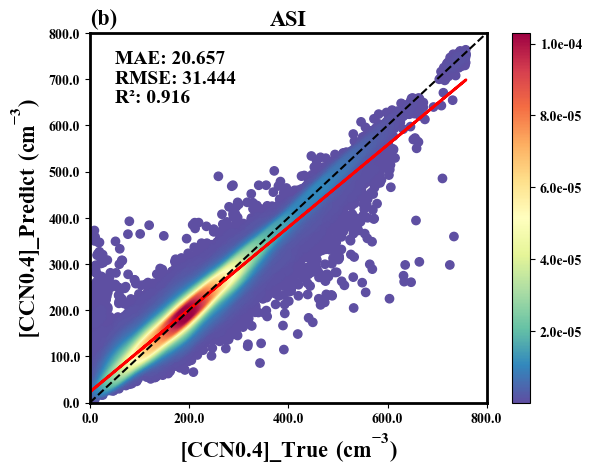

In [34]:

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'


def density_scatter(x, y, ax=None, is_cbar=False, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    ax.scatter(x, y, c=z, cmap='Spectral_r')

    if is_cbar:
        norm = Normalize(vmin=np.min(z), vmax=np.max(z))
        cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap='Spectral_r'), ax=ax)
        cbar.ax.tick_params(labelsize=10)  
        cbar.ax.set_yticklabels(['{:.1e}'.format(t) for t in cbar.get_ticks()], fontname='Times New Roman') 

    return ax


x = y_test_asi.to_numpy()
y = predictions_asi

fig = plt.figure()
ax = fig.add_subplot(111)

ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

density_scatter(x=x, y=y, ax=ax, is_cbar=True)

slope, intercept, r_value, p_value, std_err = linregress(x, y)

regression_line = slope * x + intercept
plt.plot(x, regression_line, 'red', lw=2, label='线性回归线')

plt.plot([0, 800], [0, 800], 'black', lw=1.5, linestyle='--')  # 1:1
plt.axis([0, 800, 0, 800])

ax.tick_params(axis='both', labelsize=14)

ax.set_xticklabels(ax.get_xticks(), size=14)
ax.set_yticklabels(ax.get_yticks(), size=14)

BIAS_asi = mean(x - y)
MSE_asi = mean_squared_error(x, y)
RMSE_asi = np.power(MSE_asi, 0.5)
R2_asi = r2_score(x, y)
MAE_asi = mean_absolute_error(x, y)
EV_asi = explained_variance_score(x, y)

text = f'\nMAE: {MAE_asi:.3f}\nRMSE: {RMSE_asi:.3f}\nR²: {R2_asi:.3f}'
plt.yticks(fontsize=10, fontname='Times New Roman', fontweight='bold')
plt.xticks(fontsize=10, fontname='Times New Roman', fontweight='bold')
plt.xlabel(r'[CCN0.4]_True$\mathregular{\ (cm^{-3})}$', fontsize=16, fontname='Times New Roman', fontweight='bold')
plt.ylabel(r'[CCN0.4]_Predict$\mathregular{\ (cm^{-3})}$', fontsize=16, fontname='Times New Roman', fontweight='bold')
plt.title('(b)', loc='left', fontsize=16, fontname='Times New Roman', fontweight='bold')
plt.title('ASI', fontsize=16, fontname='Times New Roman', fontweight='bold')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.text(50,650, text, fontsize=14, fontname='Times New Roman')
# plt.savefig('E:/aabc/summary/fig-240727/asi.png',dpi=300,bbox_inches='tight',pad_inches=0)

plt.show()


## <a id='toc4_4_'></a>[SHAP for ASI](#toc0_)

In [ ]:
# SHAP interactions are based on the xgboost model
xgb_model_asi = XGBRegressor(**opt_xgb_best_params_asi, n_jobs=-1)
xgb_model_asi.fit(X_train_asi, y_train_asi)
xgb_predictions_asi = xgb_model_asi.predict(X_test_asi)

In [38]:
# Randomly select 3000 samples for SHAP analysis
np.random.seed(2024)
indices_asi = np.random.choice(X_test_asi.shape[0], 3000, replace=False)
selected_X_test_asi = X_test_asi.iloc[indices_asi]
# selected_X_test_asi = X_test_asi  # Comment this out if using the random subset
# Create an explainer
explainer = shap.TreeExplainer(xgb_model_asi)
# Compute SHAP interaction values
shap_interaction_values_asi = explainer.shap_interaction_values(selected_X_test_asi)


In [ ]:
# shap
explainer = shap.KernelExplainer(ensemble_model_asi.predict, data=X_train_asi.sample(100))
shap_values_asi = explainer.shap_values(X_test_asi.iloc[indices_asi])


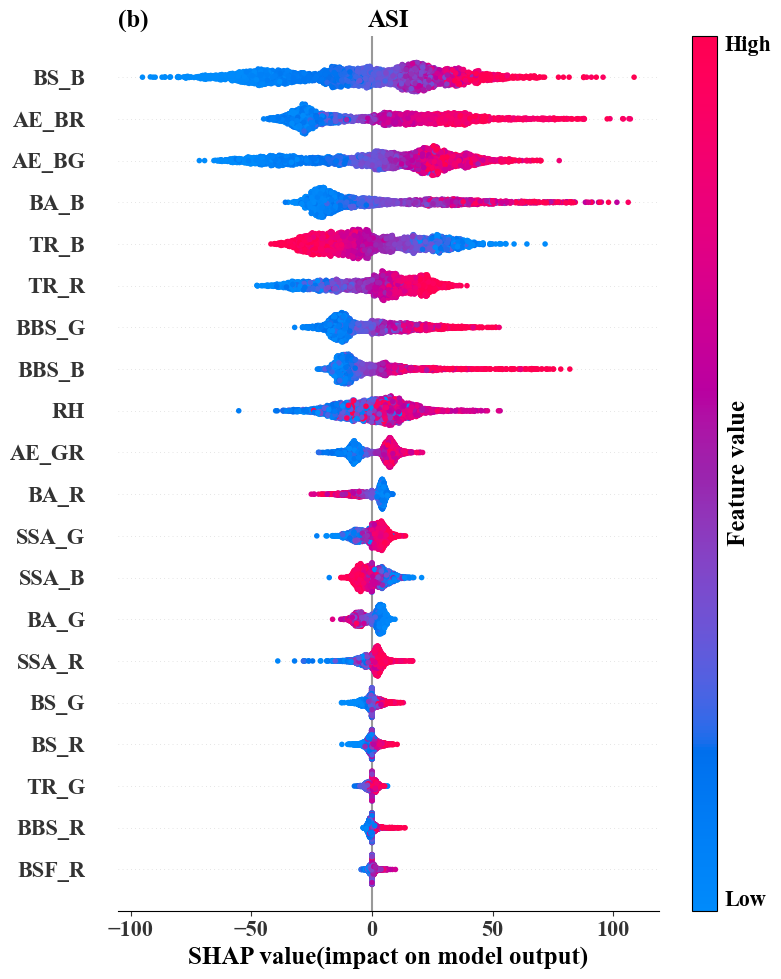

In [39]:
# summary
import os
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'

shap.summary_plot(shap_values_asi, selected_X_test_asi, show=False,color_bar=False)
cbar = plt.colorbar(aspect=35)
cbar.set_label('Feature value',size=18,fontname='Times New Roman', fontweight='bold')
cbar.ax.set_yticklabels([])
cbar.ax.tick_params(axis='y', which='both', length=0)
cbar.ax.text(1.3,0,'Low',va='bottom',ha='left',transform=cbar.ax.transAxes,fontsize=16)
cbar.ax.text(1.3,1,'High',va='top',ha='left',transform=cbar.ax.transAxes,fontsize=16)

plt.xlabel('SHAP value(impact on model output)',fontsize=18,fontname='Times New Roman', fontweight='bold')
plt.tick_params(axis='x',labelsize=16)
plt.tick_params(axis='y',labelsize=16)
plt.title('(b)', loc='left', fontsize=18, fontname='Times New Roman', fontweight='bold')
plt.title('ASI', fontsize=18, fontname='Times New Roman', fontweight='bold')
# plt.savefig('E:/aabc/summary/fig-240804/shap-ena.png',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()


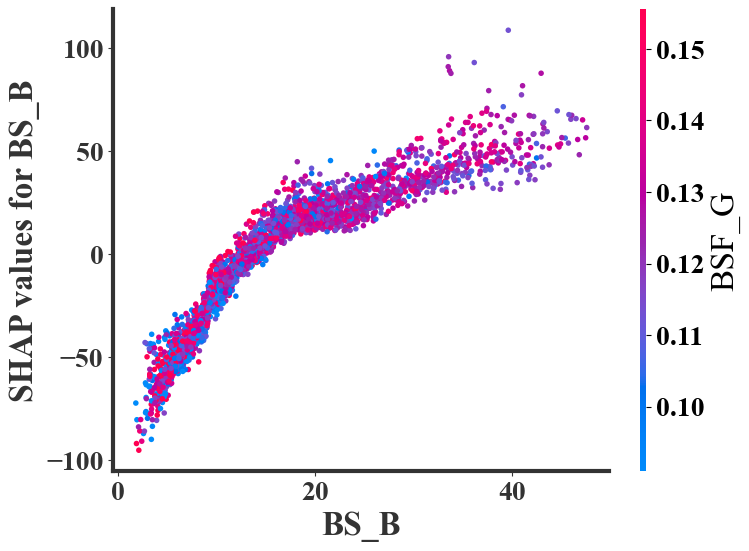

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))
shap.dependence_plot('BS_B', shap_values_asi, selected_X_test_asi, interaction_index='BSF_G', ax=ax, show=False)
# dependence

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20) 
cbar.set_label('BSF_G', fontsize=24) 
ax.set_xlabel('BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# plt.savefig('E:/aabc/summary/fig-240804/asi11.png',dpi=300,bbox_inches='tight',pad_inches=0)

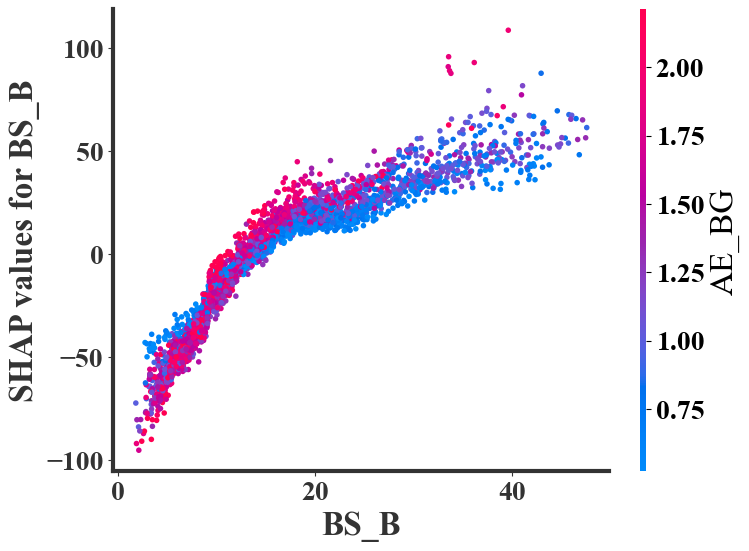

In [41]:
fig, ax = plt.subplots(figsize=(8, 6))
shap.dependence_plot('BS_B', shap_values_asi, selected_X_test_asi, interaction_index='AE_BG', ax=ax, show=False)
# dependence

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20) 
cbar.set_label('AE_BG', fontsize=24) 
ax.set_xlabel('BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# plt.savefig('E:/aabc/summary/fig-240804/asi1.png',dpi=300,bbox_inches='tight',pad_inches=0)

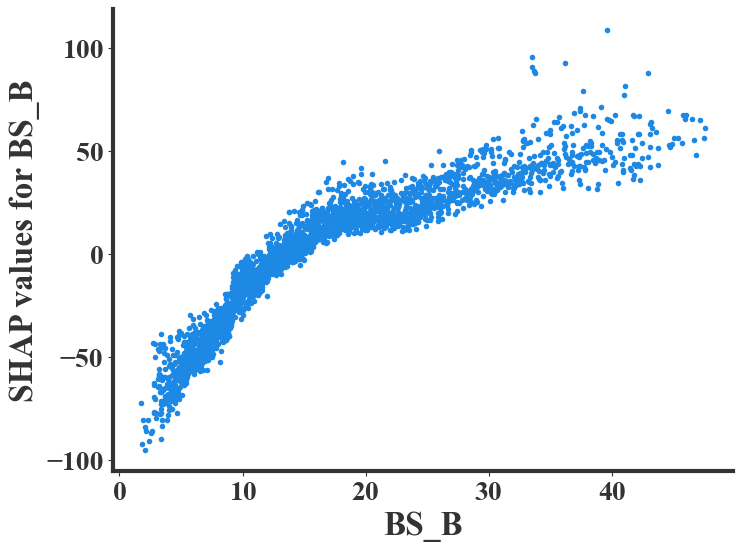

In [42]:
fig, ax = plt.subplots(figsize=(8, 6))
shap.dependence_plot('BS_B', shap_values_asi, selected_X_test_asi, interaction_index=None, ax=ax, show=False)
# dependence

# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=20) 
# cbar.set_label('AE_BG', fontsize=24)
ax.set_xlabel('BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# plt.savefig('E:/aabc/summary/fig-240804/asi2.png',dpi=300,bbox_inches='tight',pad_inches=0)

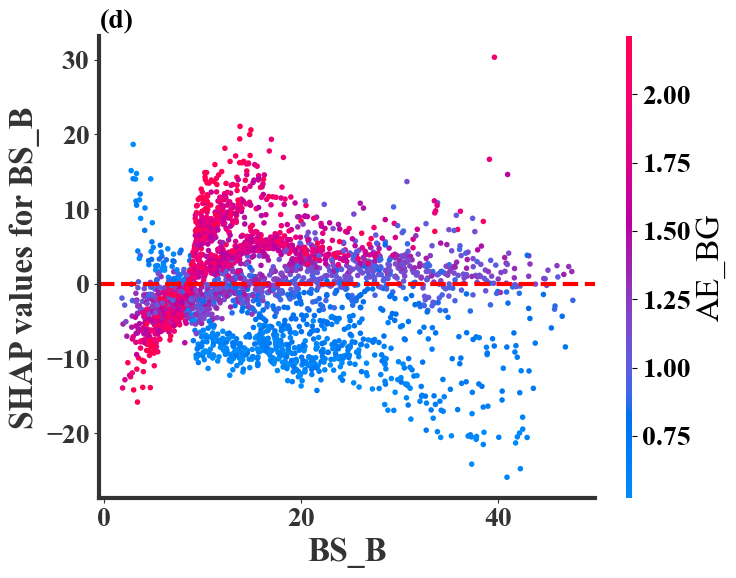

In [43]:
fig, ax = plt.subplots(figsize=(8, 6))
# interaction
shap.dependence_plot(
    "BS_B",  # key feature
    shap_interaction_values_asi[:, :, selected_X_test_asi.columns.get_loc("AE_BG")],  
    selected_X_test_asi,
    interaction_index="AE_BG",  # interactive feature
    ax=ax,
    show=False
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20) 
cbar.set_label('AE_BG', fontsize=24) 
ax.set_xlabel('BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_title('(d)', loc='left', fontsize=20, fontname='Times New Roman', fontweight='bold')
ax.axhline(0, color='red', linestyle='--', linewidth=3)
# plt.savefig('E:/aabc/summary/fig-240804/asi3t.png',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()


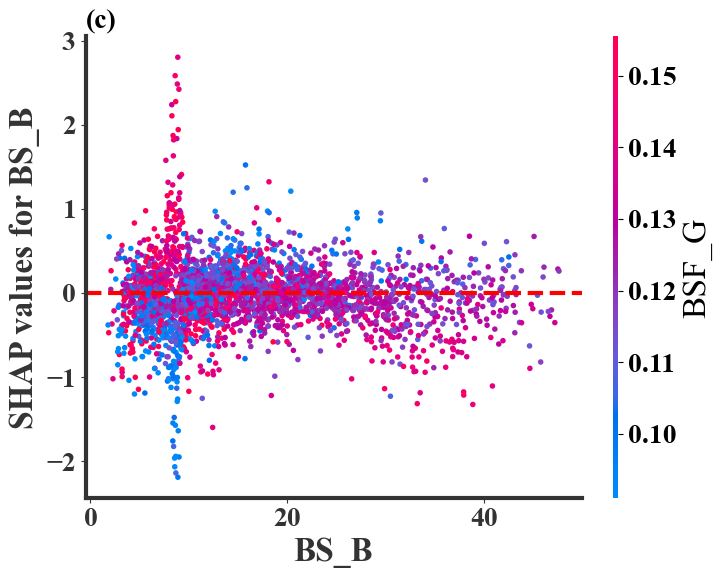

In [44]:
fig, ax = plt.subplots(figsize=(8, 6))
# interaction
shap.dependence_plot(
    "BS_B",  # key feature
    shap_interaction_values_asi[:, :, selected_X_test_asi.columns.get_loc("BSF_G")],  
    selected_X_test_asi,
    interaction_index="BSF_G",  # interactive feature
    ax=ax,
    show=False
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20) 
cbar.set_label('BSF_G', fontsize=24)
ax.set_xlabel('BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_title('(c)', loc='left', fontsize=20, fontname='Times New Roman', fontweight='bold')
ax.axhline(0, color='red', linestyle='--', linewidth=3)
# plt.savefig('E:/aabc/summary/fig-240804/asi33t.png',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()


In [45]:
# save
shap_values_df_asi = pd.DataFrame(shap_values_asi, columns=X_train_asi.columns)

shap_values_df_asi
# shap_values_df_asi.to_csv('E:/aabc\myDeepTree\data-240801/asishap_values.csv', index=False)

feature_importance_asi = np.abs(shap_values_df_asi).mean().sort_values(ascending=False)
# feature_importance_asi.to_csv('E:/aabc\myDeepTree\data-240801/asifeature_importance.csv')
total_shap_asi = feature_importance_asi.sum()

# contribution_ratio
feature_contribution_ratio_asi = (feature_importance_asi / total_shap_asi) * 100

# feature_contribution_ratio_asi.to_csv('E:/aabc\myDeepTree\data-240801/asifeature_contribution_ratio.csv')
feature_contribution_ratio_asi

BS_B     13.066082
AE_BR    12.369215
AE_BG    11.982967
BA_B     10.838746
TR_B      8.322376
TR_R      7.204366
BBS_G     6.221156
BBS_B     5.601250
RH        5.195020
AE_GR     3.659809
BA_R      2.354040
SSA_G     2.133907
SSA_B     2.086638
BA_G      1.998884
SSA_R     1.667425
BS_G      1.235098
BS_R      0.904814
TR_G      0.696583
BBS_R     0.576407
BSF_R     0.446869
g_G       0.339983
BSF_B     0.323961
BSF_G     0.295148
g_R       0.256178
g_B       0.223080
dtype: float64

# <a id='toc5_'></a>[GUC](#toc0_)
## <a id='toc5_1_'></a>[Model](#toc0_)

In [52]:
# data reading
data_guc = pd.read_csv('E:/aabc\myDeepTree\data-240321/gucTP.csv')
data_guc = data_guc.replace(-9999, float('nan'))
data_guc.iloc[:, 0] = pd.to_numeric(data_guc.iloc[:, 0], errors='coerce')
data_guc = data_guc.dropna()
data_guc.columns = [
    'CCN', 'BS_B', 'BS_G', 'BS_R', 'AE_BG', 'AE_BR', 'AE_GR', 'BBS_B', 'BBS_G', 'BBS_R',
    'BSF_B', 'BSF_G', 'BSF_R', 'g_B', 'g_G', 'g_R', 'SSA_B', 'SSA_G', 'SSA_R', 
    'TR_B', 'TR_G', 'TR_R','RH', 'BA_B', 'BA_G', 'BA_R'
]
data_guc

CCN       BS_B       BS_G       BS_R     AE_BG     AE_BR  \
5      550.952217  43.145440  33.368600  21.876892  1.959982  2.041535   
6      560.005709  75.337860  57.593580  35.800575  2.048541  2.247578   
9      567.910617  55.117252  43.960804  27.433380  1.725078  2.129572   
10     606.038636  56.522476  44.164368  28.202677  1.881867  2.103782   
17     544.077867  75.579510  57.887917  36.372140  2.034087  2.207130   
...           ...        ...        ...        ...       ...       ...   
61915  195.423545   3.680213   2.841957   2.244977  1.971549  1.424857   
61916  187.544351   4.238627   3.566895   2.670544  1.316087  1.390571   
61917  184.844114   4.214589   3.455849   2.598696  1.513944  1.440298   
61918  182.365281   3.653721   2.866382   2.119565  1.851169  1.605619   
61919  177.549905   3.956822   3.008666   1.959815  2.089522  2.105093   

          AE_GR     BBS_B     BBS_G     BBS_R  ...     SSA_B     SSA_G  \
5      2.109395  4.909241  4.420276  3.563093  ...  0.987983  0.985023   
6      2.413197  7.810824  6.944680  5.786875  ...  1.002678  1.001679   
9      2.466151  6.214628  4.835032  4.199146  ...  0.996957  0.993185   
10     2.288437  5.545890  4.923078  4.298800  ...  1.013708  1.012138   
17     2.351119  8.184023  6.635899  5.914550  ...  1.020131  1.022576   
...         ...       ...       ...       ...  ...       ...       ...   
61915  0.969954  0.915781  0.540702  0.698998  ...  0.679506  0.653280   
61916  1.452550  0.818851  0.544277  0.699531  ...  0.709268  0.700320   
61917  1.379017  0.835356  0.660224  0.702542  ...  0.709746  0.695051   
61918  1.401296  0.654492  0.509239  0.406190  ...  0.713932  0.693903   
61919  2.118048  0.715893  0.355415  0.264476  ...  0.806509  0.777591   

          SSA_R      TR_B      TR_G      TR_R         RH      BA_B      BA_G  \
5      0.980067  0.937652  0.946264  0.956325  35.836365  1.269633  1.096592   
6      0.996225  0.937478  0.946114  0.956201  36.100000  1.068737  0.901157   
9      0.981597  0.934336  0.943144  0.953586  32.750000  1.108316  1.064827   
10     1.009990  0.934230  0.943033  0.953479  32.358334  0.113473  0.170972   
17     1.026622  0.935593  0.944286  0.954500  35.416668 -0.357495 -0.402158   
...         ...       ...       ...       ...        ...       ...       ...   
61915  0.654048  0.985214  0.987284  0.989629  12.950000  1.855158  1.602979   
61916  0.695836  0.984906  0.987016  0.989421  13.100000  1.858130  1.632458   
61917  0.690153  0.984625  0.986766  0.989230  12.916666  1.844844  1.620458   
61918  0.684290  0.984341  0.986520  0.989037  12.966666  1.570886  1.351806   
61919  0.746282  0.984141  0.986343  0.988901  13.100000  1.046975  0.939618   

           BA_R  
5      0.837468  
6      0.767810  
9      1.005721  
10     0.202542  
17    -0.410332  
...         ...  
61915  1.262073  
61916  1.249120  
61917  1.247090  
61918  1.044314  
61919  0.721379  

[50735 rows x 26 columns]

In [53]:
def remove_outliers(df):
    # Remove outliers using the 3-sigma rule
    for column in df.columns:
        mean = df[column].mean()
        std = df[column].std()
        cutoff = std * 3
        lower = mean - cutoff
        upper = mean + cutoff
        df = df[(df[column] > lower) & (df[column] < upper)]
    return df

# Apply function to remove outliers
data_guc = remove_outliers(data_guc)
data_guc


CCN       BS_B       BS_G       BS_R     AE_BG     AE_BR  \
9      567.910617  55.117252  43.960804  27.433380  1.725078  2.129572   
115    491.612221  63.674225  49.834415  31.511812  1.869311  2.132469   
116    504.542269  67.234930  52.973976  32.136272  1.818345  2.253974   
117    549.155239  77.575810  59.809303  37.609780  1.983881  2.188143   
118    544.227930  73.364655  57.719060  35.774790  1.829503  2.186124   
...           ...        ...        ...        ...       ...       ...   
61663  118.828535   2.658496   2.136248   1.561916  1.668216  1.583843   
61819  165.657559   2.625966   2.059236   1.480587  1.854360  1.700048   
61839  153.672413   2.937862   2.363200   1.559320  1.660249  1.922883   
61872  172.351058   2.778204   2.255061   1.840278  1.591319  1.193127   
61886  181.790750   3.136564   2.401272   1.659841  2.037539  1.890593   

          AE_GR     BBS_B     BBS_G     BBS_R  ...     SSA_B     SSA_G  \
9      2.466151  6.214628  4.835032  4.199146  ...  0.996957  0.993185   
115    2.351442  7.076651  5.365071  4.464237  ...  0.958183  0.952673   
116    2.616462  6.625530  5.919486  4.691011  ...  0.957728  0.952304   
117    2.358109  7.647809  6.320363  5.286356  ...  0.960888  0.955593   
118    2.482868  7.477943  6.451732  5.311398  ...  0.959849  0.955232   
...         ...       ...       ...       ...  ...       ...       ...   
61663  1.513636  0.429092  0.424553  0.317157  ...  0.954521  0.926627   
61819  1.571646  0.521734  0.341327  0.341199  ...  0.941813  0.889058   
61839  2.141421  0.385938  0.356668  0.342058  ...  0.945585  0.980836   
61872  0.861793  0.263386  0.340004  0.327558  ...  0.937994  0.903028   
61886  1.768319  0.510861  0.451270  0.288853  ...  0.942377  0.912314   

          SSA_R      TR_B      TR_G      TR_R         RH      BA_B      BA_G  \
9      0.981597  0.934336  0.943144  0.953586  32.750000  1.108316  1.064827   
115    0.938560  0.940617  0.949528  0.960026  33.733334  3.934397  3.398772   
116    0.934589  0.940074  0.949049  0.959642  33.550000  4.186866  3.635862   
117    0.940851  0.939470  0.948525  0.959218  33.600000  4.562293  3.883175   
118    0.941418  0.938861  0.947994  0.958797  33.600000  4.394901  3.769745   
...         ...       ...       ...       ...        ...       ...       ...   
61663  0.929890  0.829919  0.855731  0.884562  11.033334  0.171758  0.206726   
61819  0.882290  0.992250  0.993156  0.994163  11.483334  0.212637  0.300879   
61839  0.981248  0.991314  0.992205  0.993474  11.400000  0.224794  0.088412   
61872  0.919131  0.989772  0.991138  0.992595  11.483334  0.237051  0.288567   
61886  0.896117  0.989197  0.990494  0.992114  11.375000  0.253100  0.280065   

           BA_R  
9      1.005721  
115    2.668036  
116    2.871833  
117    3.084042  
118    2.910587  
...         ...  
61663  0.145937  
61819  0.229698  
61839  0.057921  
61872  0.198794  
61886  0.227420  

[38128 rows x 26 columns]

In [54]:
data_guc = data_guc[data_guc['CCN'] >0]
data_guc = data_guc[data_guc['SSA_B']<1]
data_guc = data_guc[data_guc['SSA_G']<1]
data_guc = data_guc[data_guc['SSA_R']<1]
data_guc = data_guc[data_guc['BA_B']>0]
data_guc = data_guc[data_guc['BA_G']>0]
data_guc = data_guc[data_guc['BA_R']>0]
# data = data.loc[0:456806,:]# The first 200,000 groups of data in the sgp

# Prepare features and target variable
X_guc = data_guc.drop('CCN', axis=1)  # Features
y_guc = data_guc['CCN']  # Features
X_train_guc, X_test_guc, y_train_guc, y_test_guc = train_test_split(X_guc, y_guc, test_size=0.2, random_state=2024)

In [ ]:

xgb_params = {
    'n_estimators': Integer(50, 1000),
    'max_depth': Integer(3, 16),
    'learning_rate': Real(0.01, 0.4, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'random_state': Categorical([2024]),  
   
}



rf_params = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 16),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 6),
    'random_state': Categorical([2024])  
}


cb_params = {
    'iterations': Integer(50, 1000),
    'depth': Integer(3, 16),
    'learning_rate': Real(0.01, 0.4, prior='log-uniform'),
    'l2_leaf_reg': Real(0.05, 10, prior='log-uniform'),
    'random_state': Categorical([2024]),  
    # 'task_type': Categorical(['GPU']),  
    # 'devices': Categorical(['0:1']),
    'train_dir': Categorical(["./catboost_info"])  
}


opt_xgb = BayesSearchCV(XGBRegressor(), xgb_params, n_iter=10, cv=5, n_jobs=-1, verbose=10)
opt_rf = BayesSearchCV(RandomForestRegressor(), rf_params, n_iter=10, cv=5, n_jobs=-1, verbose=10)
opt_cb = BayesSearchCV(CatBoostRegressor(verbose=0), cb_params, n_iter=10, cv=5, n_jobs=-1, verbose=10)


opt_xgb.fit(X_train, y_train)
opt_rf.fit(X_train, y_train)
opt_cb.fit(X_train, y_train)

print("Best XGBoost params:", opt_xgb.best_params_)
print("Best RF params:", opt_rf.best_params_)
print("Best CatBoost params:", opt_cb.best_params_)


In [ ]:
from sklearn.ensemble import VotingRegressor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Plot Bayesian optimization process
def plot_optimization_results(opt, model_name):
    results = opt.cv_results_
    best_scores = -np.array(results['mean_test_score'])
    plt.plot(best_scores, marker='o', label=f'{model_name} Best Score')
    plt.xlabel('Iteration')
    plt.ylabel('Neg Mean Test Score')
    plt.title(f'{model_name} Optimization')
    plt.legend()

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plot_optimization_results(opt_xgb, "XGBoost")
plt.subplot(1, 3, 2)
plot_optimization_results(opt_rf, "Random Forest")
plt.subplot(1, 3, 3)
plot_optimization_results(opt_cb, "CatBoost")
plt.tight_layout()
plt.show()

# Create models with best parameters
xgb_best = XGBRegressor(**opt_xgb.best_params_, n_jobs=-1)
rf_best = RandomForestRegressor(**opt_rf.best_params_, n_jobs=-1)
cb_best = CatBoostRegressor(**opt_cb.best_params_, verbose=0)

# Create ensemble model
ensemble_model = VotingRegressor(estimators=[
    ('xgb', xgb_best),
    ('rf', rf_best),
    ('cb', cb_best)
])

# Train ensemble model
ensemble_model.fit(X_train, y_train)

# Make predictions
predictions = ensemble_model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')


## <a id='toc5_2_'></a>[Load the best parameters directly](#toc0_)
### <a id='toc5_2_1_'></a>[If you want to reproduce the results of the paper, please use the following parameters in the parameter file or attachment](#toc0_)

In [ ]:
# If you want to reproduce the work of the paper, please use the following parameter file or use the attached parameters
opt_xgb_best_params_guc = np.load('E:/aabc/myDeepTree/data-240801/gucxgb.npy', allow_pickle=True).item()
opt_rf_best_params_guc = np.load('E:/aabc/myDeepTree/data-240801/gucrf.npy', allow_pickle=True).item()
opt_cb_best_params_guc = np.load('E:/aabc/myDeepTree/data-240801/guccb.npy', allow_pickle=True).item()
print(opt_xgb_best_params_guc,opt_rf_best_params_guc,opt_cb_best_params_guc)

In [ ]:
# Use optimal parameters
xgb_best_guc= XGBRegressor(**opt_xgb_best_params_guc, n_jobs=-1)
rf_best_guc = RandomForestRegressor(**opt_rf_best_params_guc, n_jobs=-1)
# xgb_best = XGBRegressor(**opt_xgb_best_params)
# rf_best = RandomForestRegressor(**opt_rf_best_params)
cb_best_guc = CatBoostRegressor(**opt_cb_best_params_guc, verbose=0)

# Create an integration model
ensemble_model_guc = VotingRegressor(estimators=[
    ('xgb', xgb_best_guc),
    ('rf', rf_best_guc),
    ('cb', cb_best_guc)
])

ensemble_model_guc.fit(X_train_guc, y_train_guc)

predictions_guc = ensemble_model_guc.predict(X_test_guc)
mse_guc = mean_squared_error(y_test_guc, predictions_guc)
print(f'Mean Squared Error: {mse_guc}')


## <a id='toc5_3_'></a>[Data visualization](#toc0_)

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


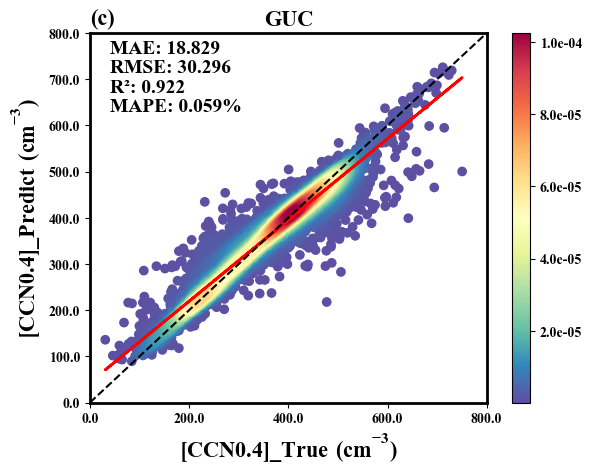

In [ ]:

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'


def density_scatter(x, y, ax=None, is_cbar=False, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    ax.scatter(x, y, c=z, cmap='Spectral_r')

    if is_cbar:
        norm = Normalize(vmin=np.min(z), vmax=np.max(z))
        cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap='Spectral_r'), ax=ax)
        cbar.ax.tick_params(labelsize=10)  
        cbar.ax.set_yticklabels(['{:.1e}'.format(t) for t in cbar.get_ticks()], fontname='Times New Roman') 

    return ax


x = y_test.to_numpy()
y = predictions

fig = plt.figure()
ax = fig.add_subplot(111)

ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

density_scatter(x=x, y=y, ax=ax, is_cbar=True)

slope, intercept, r_value, p_value, std_err = linregress(x, y)

regression_line = slope * x + intercept
plt.plot(x, regression_line, 'red', lw=2, label='线性回归线')

plt.plot([0, 800], [0, 800], 'black', lw=1.5, linestyle='--')  # 1:1
plt.axis([0, 800, 0, 800])

ax.tick_params(axis='both', labelsize=14)

ax.set_xticklabels(ax.get_xticks(), size=14)
ax.set_yticklabels(ax.get_yticks(), size=14)

BIAS_guc = mean(x - y)
MSE_guc = mean_squared_error(x, y)
RMSE_guc = np.power(MSE_guc, 0.5)
R2_guc = r2_score(x, y)
MAE_guc = mean_absolute_error(x, y)
EV_guc = explained_variance_score(x, y)
MAPE_guc = mean_absolute_percentage_error(x, y)
text = f'\nMAE: {MAE_guc:.3f}\nRMSE: {RMSE_guc:.3f}\nR²: {R2_guc:.3f}\nMAPE: {MAPE_guc:.3f}%'
plt.yticks(fontsize=10, fontname='Times New Roman', fontweight='bold')
plt.xticks(fontsize=10, fontname='Times New Roman', fontweight='bold')
plt.xlabel(r'[CCN0.4]_True$\mathregular{\ (cm^{-3})}$', fontsize=16, fontname='Times New Roman', fontweight='bold')
plt.ylabel(r'[CCN0.4]_Predict$\mathregular{\ (cm^{-3})}$', fontsize=16, fontname='Times New Roman', fontweight='bold')
plt.title('(c)', loc='left', fontsize=16, fontname='Times New Roman', fontweight='bold')
plt.title('GUC', fontsize=16, fontname='Times New Roman', fontweight='bold')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.text(40,630, text, fontsize=14, fontname='Times New Roman')
plt.savefig('E:/aabc/summary/fig-240804/guc.png',dpi=300,bbox_inches='tight',pad_inches=0)

plt.show()


## <a id='toc5_4_'></a>[SHAP for GUC](#toc0_)

In [ ]:
# SHAP interactions are based on the xgboost model
xgb_model_guc = XGBRegressor(**opt_xgb_best_params_guc, n_jobs=-1)
xgb_model_guc.fit(X_train_guc, y_train_guc)
xgb_predictions_guc = xgb_model_guc.predict(X_test_guc)

In [55]:
# Randomly select 3000 samples for SHAP analysis
np.random.seed(2024)
indices_guc = np.random.choice(X_test_guc.shape[0], 3000, replace=False)
selected_X_test_guc = X_test_guc.iloc[indices_guc]


In [ ]:
# selected_X_test_guc = X_test_guc  # Comment this out if using the random subset
# Create an explainer
explainer = shap.TreeExplainer(xgb_model_guc)
# Compute SHAP interaction values
shap_interaction_values_guc = explainer.shap_interaction_values(selected_X_test_guc)


In [ ]:
# shap
explainer = shap.KernelExplainer(ensemble_model.predict, data=X_train.sample(100))
shap_values = explainer.shap_values(X_test.iloc[indices])


X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  0%|          | 0/3000 [00:00<?, ?it/s]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  0%|          | 1/3000 [00:03<3:09:05,  3.78s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  0%|          | 2/3000 [00:07<3:05:19,  3.71s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  0%|          | 3/3000 [00:11<3:03:30,  3.67s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was

In [57]:
shap_values_guc = np.load('E:/aabc/myDeepTree/data-240806/gucshap_values.npy')
shap_interaction_values_guc = np.load('E:/aabc/myDeepTree/data-240806/gucshap_interaction_values.npy')

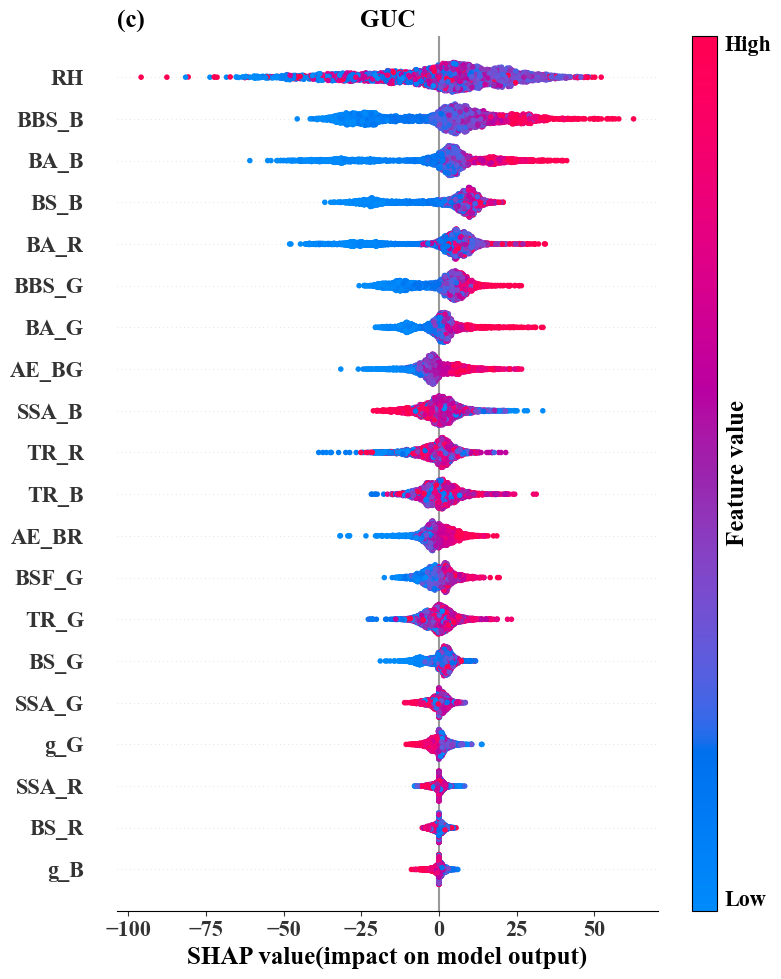

In [58]:
# summary
import os
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'

shap.summary_plot(shap_values_guc, selected_X_test_guc, show=False,color_bar=False)
cbar = plt.colorbar(aspect=35)
cbar.set_label('Feature value',size=18,fontname='Times New Roman', fontweight='bold')
cbar.ax.set_yticklabels([])
cbar.ax.tick_params(axis='y', which='both', length=0)
cbar.ax.text(1.3,0,'Low',va='bottom',ha='left',transform=cbar.ax.transAxes,fontsize=16)
cbar.ax.text(1.3,1,'High',va='top',ha='left',transform=cbar.ax.transAxes,fontsize=16)

plt.xlabel('SHAP value(impact on model output)',fontsize=18,fontname='Times New Roman', fontweight='bold')
plt.tick_params(axis='x',labelsize=16)
plt.tick_params(axis='y',labelsize=16)
plt.title('(c)', loc='left', fontsize=18, fontname='Times New Roman', fontweight='bold')
plt.title('GUC', fontsize=18, fontname='Times New Roman', fontweight='bold')
# plt.savefig('E:/aabc/summary/fig-240804/shap-guc.png',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()


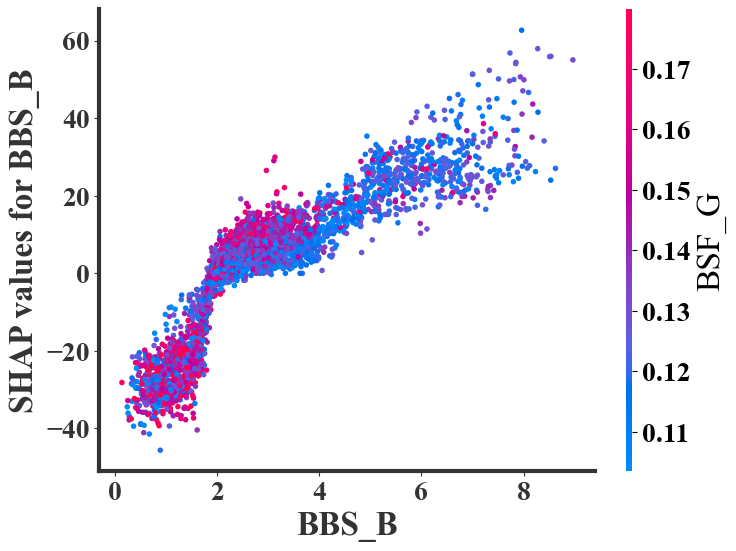

In [60]:
fig, ax = plt.subplots(figsize=(8, 6))
shap.dependence_plot('BBS_B', shap_values_guc, selected_X_test_guc, interaction_index='BSF_G', ax=ax, show=False)
# dependence

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20) 
cbar.set_label('BSF_G', fontsize=24) 
ax.set_xlabel('BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# plt.savefig('E:/aabc/summary/fig-240804/guc1.png',dpi=300,bbox_inches='tight',pad_inches=0)

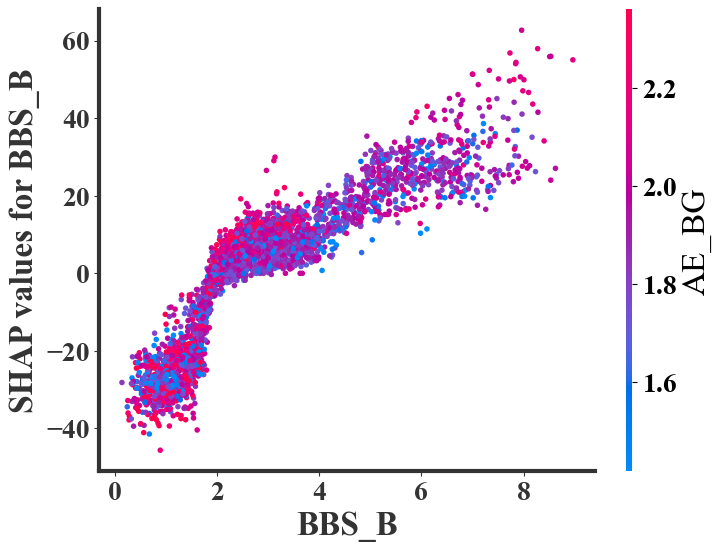

In [64]:
fig, ax = plt.subplots(figsize=(8, 6))
shap.dependence_plot('BBS_B', shap_values_guc, selected_X_test_guc, interaction_index='AE_BG', ax=ax, show=False)
# dependence

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20) 
cbar.set_label('AE_BG', fontsize=24) 
ax.set_xlabel('BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# plt.savefig('E:/aabc/summary/fig-240804/guc1.png',dpi=300,bbox_inches='tight',pad_inches=0)

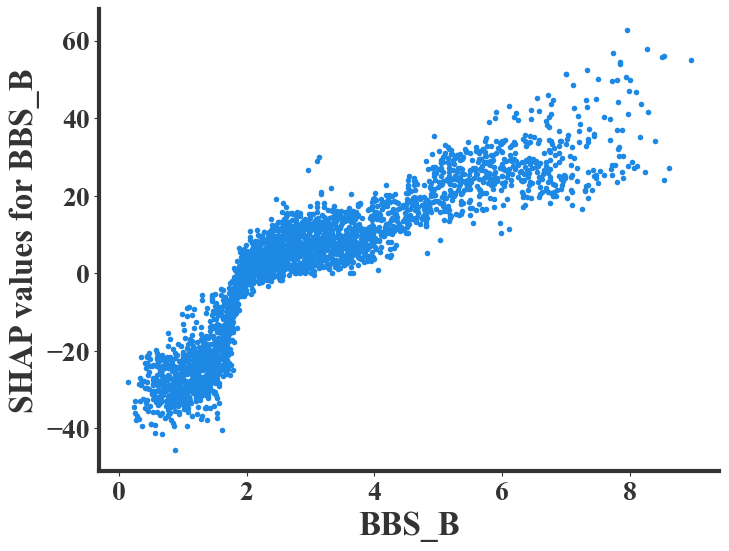

In [61]:
fig, ax = plt.subplots(figsize=(8, 6))
shap.dependence_plot('BBS_B', shap_values_guc, selected_X_test_guc, interaction_index=None, ax=ax, show=False)
# dependence

# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=20) 
# cbar.set_label('AE_BG', fontsize=24)
ax.set_xlabel('BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# plt.savefig('E:/aabc/summary/fig-240804/guc2.png',dpi=300,bbox_inches='tight',pad_inches=0)

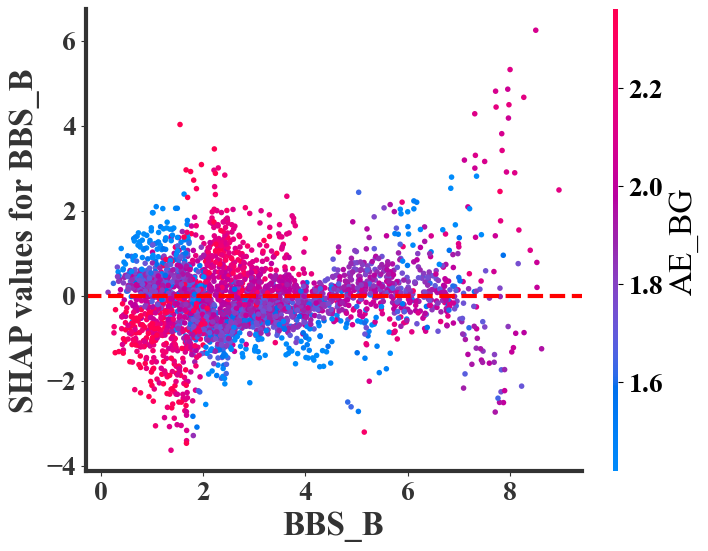

In [62]:
fig, ax = plt.subplots(figsize=(8, 6))
# interaction
shap.dependence_plot(
    "BBS_B",  # key feature
    shap_interaction_values_guc[:, :, selected_X_test_guc.columns.get_loc("AE_BG")],  
    selected_X_test_guc,
    interaction_index="AE_BG",  # interactive feature
    ax=ax,
    show=False
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20) 
cbar.set_label('AE_BG', fontsize=24) 
ax.set_xlabel('BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# ax.set_title('(f)', loc='left', fontsize=20, fontname='Times New Roman', fontweight='bold')
ax.axhline(0, color='red', linestyle='--', linewidth=3)
# plt.savefig('E:/aabc/summary/fig-240804/guc33.png',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()


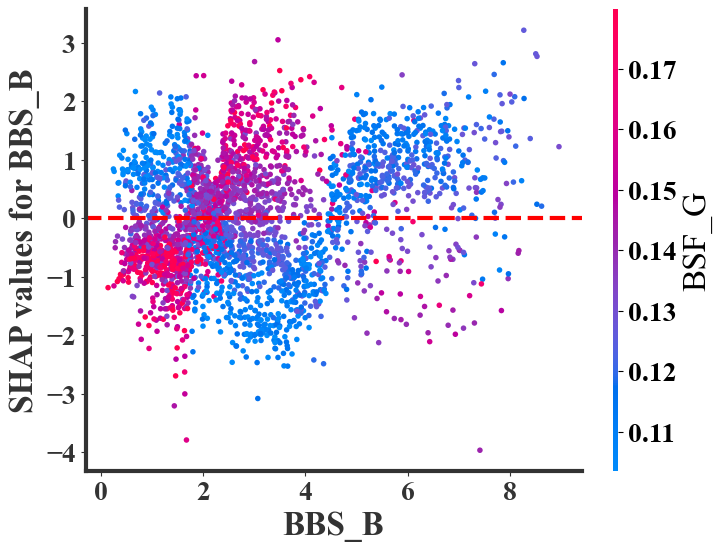

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))
# interaction
shap.dependence_plot(
    "BBS_B",  # key feature
    shap_interaction_values_guc[:, :, selected_X_test_guc.columns.get_loc("BSF_G")],  
    selected_X_test_guc,
    interaction_index="BSF_G",  # interactive feature
    ax=ax,
    show=False
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20) 
cbar.set_label('BSF_G', fontsize=24) 
ax.set_xlabel('BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# ax.set_title('(e)', loc='left', fontsize=20, fontname='Times New Roman', fontweight='bold')
ax.axhline(0, color='red', linestyle='--', linewidth=3)
# plt.savefig('E:/aabc/summary/fig-240804/guc3.png',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()


In [65]:
# save
shap_values_df_guc = pd.DataFrame(shap_values_guc, columns=X_train_guc.columns)

shap_values_df_guc
# shap_values_df_guc.to_csv('E:/aabc\myDeepTree\data-240806/gucshap_values.csv', index=False)

feature_importance_guc = np.abs(shap_values_df_guc).mean().sort_values(ascending=False)
# feature_importance_guc.to_csv('E:/aabc\myDeepTree\data-240806/gucfeature_importance.csv')
total_shap_guc = feature_importance_guc.sum()

# contribution_ratio
feature_contribution_ratio_guc = (feature_importance_guc / total_shap_guc) * 100

# feature_contribution_ratio_guc.to_csv('E:/aabc\myDeepTree\data-240806/gucfeature_contribution_ratio.csv')
feature_contribution_ratio_guc

RH       13.819050
BBS_B    12.734612
BA_B      9.641604
BS_B      8.935640
BA_R      8.428134
BBS_G     6.154414
BA_G      4.054266
AE_BG     3.989699
SSA_B     3.819876
TR_R      3.650744
TR_B      3.371381
AE_BR     2.966511
BSF_G     2.853095
TR_G      2.842146
BS_G      2.623911
SSA_G     1.729403
g_G       1.679125
SSA_R     1.054232
BS_R      1.050144
g_B       0.991884
BBS_R     0.946404
BSF_B     0.788437
BSF_R     0.733243
AE_GR     0.729044
g_R       0.413000
dtype: float64

# <a id='toc6_'></a>[Contribution](#toc0_)
## <a id='toc6_1_'></a>[Make sure that the contribution rates of the four sites have been calculated when running this section](#toc0_)

In [ ]:

# sgph = pd.read_csv('E:/aabc\myDeepTree\data-240520/sgphfeature_contribution_ratio.csv')# activation rate
# enah = pd.read_csv('E:/aabc\myDeepTree\data-240520/enahfeature_contribution_ratio.csv')# activation rate
# guch = pd.read_csv('E:/aabc\myDeepTree\data-240520/guchfeature_contribution_ratio.csv')# activation rate
# asih = pd.read_csv('E:/aabc\myDeepTree\data-240520/asihfeature_contribution_ratio.csv')# activation rate
# sgp = pd.read_csv('E:/aabc\myDeepTree\data-240520/sgpfeature_contribution_ratio.csv')
# ena = pd.read_csv('E:/aabc\myDeepTree\data-240520/enafeature_contribution_ratio.csv')
# asi = pd.read_csv('E:/aabc\myDeepTree\data-240520/asifeature_contribution_ratio.csv')
# guc = pd.read_csv('E:/aabc\myDeepTree\data-240520/gucfeature_contribution_ratio.csv')
sgp = feature_contribution_ratio
ena = feature_contribution_ratio_ena
asi = feature_contribution_ratio_asi
guc = feature_contribution_ratio_guc
ena

In [ ]:
# Extract variable names and corresponding values from the DataFrame
variable_names_guc = guc.iloc[:, 0].values
variable_values_guc = guc.iloc[:, 1].values

variable_dict_guc = dict(zip(variable_names_guc, variable_values_guc))

variable_names_sgp = sgp.iloc[:, 0].values
variable_values_sgp = sgp.iloc[:, 1].values

variable_dict_sgp = dict(zip(variable_names_sgp, variable_values_sgp))

variable_names_ena = ena.iloc[:, 0].values
variable_values_ena = ena.iloc[:, 1].values

variable_dict_ena = dict(zip(variable_names_ena, variable_values_ena))

variable_names_asi = asi.iloc[:, 0].values
variable_values_asi = asi.iloc[:, 1].values

variable_dict_asi = dict(zip(variable_names_asi, variable_values_asi))
# variable_names_guch = guch.iloc[:, 0].values
# variable_values_guch = guch.iloc[:, 1].values

# variable_dict_guch = dict(zip(variable_names_guch, variable_values_guch))

# variable_names_sgph = sgph.iloc[:, 0].values
# variable_values_sgph = sgph.iloc[:, 1].values

# variable_dict_sgph = dict(zip(variable_names_sgph, variable_values_sgph))

# variable_names_enah = enah.iloc[:, 0].values
# variable_values_enah = enah.iloc[:, 1].values

# variable_dict_enah = dict(zip(variable_names_enah, variable_values_enah))

# variable_names_asih = asih.iloc[:, 0].values
# variable_values_asih = asih.iloc[:, 1].values

# variable_dict_asih = dict(zip(variable_names_asih, variable_values_asih))
# variable_dict_asi

In [ ]:
AE_ASI=variable_dict_asi['AE_BG']+variable_dict_asi['AE_BR']+variable_dict_asi['AE_GR']
BS_ASI=variable_dict_asi['BS_B']+variable_dict_asi['BS_G']+variable_dict_asi['BS_R']
BA_ASI=variable_dict_asi['BA_B']+variable_dict_asi['BA_G']+variable_dict_asi['BA_R']
BBS_ASI=variable_dict_asi['BBS_B']+variable_dict_asi['BBS_G']+variable_dict_asi['BBS_R']
SSA_ASI=variable_dict_asi['SSA_B']+variable_dict_asi['SSA_G']+variable_dict_asi['SSA_R']
G_ASI=variable_dict_asi['g_B']+variable_dict_asi['g_G']+variable_dict_asi['g_R']
BSF_ASI=variable_dict_asi['BSF_B']+variable_dict_asi['BSF_G']+variable_dict_asi['BSF_R']
TRAN_ASI=variable_dict_asi['TR_B']+variable_dict_asi['TR_G']+variable_dict_asi['TR_R']
# T_ASI=variable_dict_asi['T_Neph_Dry']
RH_ASI=variable_dict_asi['RH']
# P_ASI=variable_dict_asi['P_Neph_Dry']

AE_ENA=variable_dict_ena['AE_BG']+variable_dict_ena['AE_BR']+variable_dict_ena['AE_GR']
BS_ENA=variable_dict_ena['BS_B']+variable_dict_ena['BS_G']+variable_dict_ena['BA_R']
BA_ENA=variable_dict_ena['BA_B']+variable_dict_ena['BA_G']+variable_dict_ena['BA_R']
BBS_ENA=variable_dict_ena['BBS_B']+variable_dict_ena['BBS_G']+variable_dict_ena['BBS_R']
SSA_ENA=variable_dict_ena['SSA_B']+variable_dict_ena['SSA_G']+variable_dict_ena['SSA_R']
G_ENA=variable_dict_ena['g_B']+variable_dict_ena['g_G']+variable_dict_ena['g_R']
BSF_ENA=variable_dict_ena['BSF_B']+variable_dict_ena['BSF_G']+variable_dict_ena['BSF_R']
TRAN_ENA=variable_dict_ena['TR_B']+variable_dict_ena['TR_G']+variable_dict_ena['TR_R']
# T_ENA=variable_dict_ena['T_Neph_Dry']
RH_ENA=variable_dict_ena['RH']
# P_ENA=variable_dict_ena['P_Neph_Dry']

AE_SGP=variable_dict_sgp['AE_BG']+variable_dict_sgp['AE_BR']+variable_dict_sgp['AE_GR']
BS_SGP=variable_dict_sgp['BS_B']+variable_dict_sgp['BS_G']+variable_dict_sgp['BS_R']
BA_SGP=variable_dict_sgp['BA_B']+variable_dict_sgp['BA_G']+variable_dict_sgp['BA_R']
BBS_SGP=variable_dict_sgp['BBS_B']+variable_dict_sgp['BBS_G']+variable_dict_sgp['BBS_R']
SSA_SGP=variable_dict_sgp['SSA_B']+variable_dict_sgp['SSA_G']+variable_dict_sgp['SSA_R']
G_SGP=variable_dict_sgp['g_B']+variable_dict_sgp['g_G']+variable_dict_sgp['g_R']
BSF_SGP=variable_dict_sgp['BSF_B']+variable_dict_sgp['BSF_G']+variable_dict_sgp['BSF_R']
TRAN_SGP=variable_dict_sgp['TR_B']+variable_dict_sgp['TR_G']+variable_dict_sgp['TR_R']
# T_SGP=variable_dict_sgp['T_Neph_Dry']
RH_SGP=variable_dict_sgp['RH']
# P_SGP=variable_dict_sgp['P_Neph_Dry']

AE_GUC=variable_dict_guc['AE_BG']+variable_dict_guc['AE_BR']+variable_dict_guc['AE_GR']
BS_GUC=variable_dict_guc['BS_B']+variable_dict_guc['BS_G']+variable_dict_guc['BS_R']
BA_GUC=variable_dict_guc['BA_B']+variable_dict_guc['BA_G']+variable_dict_guc['BA_R']
BBS_GUC=variable_dict_guc['BBS_B']+variable_dict_guc['BBS_G']+variable_dict_guc['BBS_R']
SSA_GUC=variable_dict_guc['SSA_B']+variable_dict_guc['SSA_G']+variable_dict_guc['SSA_R']
G_GUC=variable_dict_guc['g_B']+variable_dict_guc['g_G']+variable_dict_guc['g_R']
BSF_GUC=variable_dict_guc['BSF_B']+variable_dict_guc['BSF_G']+variable_dict_guc['BSF_R']
TRAN_GUC=variable_dict_guc['TR_B']+variable_dict_guc['TR_G']+variable_dict_guc['TR_R']
# T_GUC=variable_dict_guc['T_Neph_Dry']
RH_GUC=variable_dict_guc['RH']
# P_GUC=variable_dict_guc['P_Neph_Dry']

# AE_ASIh=variable_dict_asih['AE_BG']+variable_dict_asih['AE_BR']+variable_dict_asih['AE_GR']
# BS_ASIh=variable_dict_asih['Bs_B']+variable_dict_asih['Bs_G']+variable_dict_asih['Bs_R']
# BA_ASIh=variable_dict_asih['Ba_B_Weiss']+variable_dict_asih['Ba_G_Weiss']+variable_dict_asih['Ba_R_Weiss']
# BBS_ASIh=variable_dict_asih['Bbs_B']+variable_dict_asih['Bbs_G']+variable_dict_asih['Bbs_R']
# SSA_ASIh=variable_dict_asih['ssa_B']+variable_dict_asih['ssa_G']+variable_dict_asih['ssa_R']
# G_ASIh=variable_dict_asih['g_B']+variable_dict_asih['g_G']+variable_dict_asih['g_R']
# BSF_ASIh=variable_dict_asih['bsf_B']+variable_dict_asih['bsf_G']+variable_dict_asih['bsf_R']
# TRAN_ASIh=variable_dict_asih['transmittance_blue']+variable_dict_asih['transmittance_green']+variable_dict_asih['transmittance_red']
# T_ASIh=variable_dict_asih['T_Neph_Dry']
# RH_ASIh=variable_dict_asih['RH_Neph_Dry']
# P_ASIh=variable_dict_asih['P_Neph_Dry']

# AE_ENAh=variable_dict_enah['AE_BG']+variable_dict_enah['AE_BR']+variable_dict_enah['AE_GR']
# BS_ENAh=variable_dict_enah['Bs_B']+variable_dict_enah['Bs_G']+variable_dict_enah['Bs_R']
# BA_ENAh=variable_dict_enah['Ba_B_Weiss']+variable_dict_enah['Ba_G_Weiss']+variable_dict_enah['Ba_R_Weiss']
# BBS_ENAh=variable_dict_enah['Bbs_B']+variable_dict_enah['Bbs_G']+variable_dict_enah['Bbs_R']
# SSA_ENAh=variable_dict_enah['ssa_B']+variable_dict_enah['ssa_G']+variable_dict_enah['ssa_R']
# G_ENAh=variable_dict_enah['g_B']+variable_dict_enah['g_G']+variable_dict_enah['g_R']
# BSF_ENAh=variable_dict_enah['bsf_B']+variable_dict_enah['bsf_G']+variable_dict_enah['bsf_R']
# TRAN_ENAh=variable_dict_enah['transmittance_blue']+variable_dict_enah['transmittance_green']+variable_dict_enah['transmittance_red']
# T_ENAh=variable_dict_enah['T_Neph_Dry']
# RH_ENAh=variable_dict_enah['RH_Neph_Dry']
# P_ENAh=variable_dict_enah['P_Neph_Dry']

# AE_SGPh=variable_dict_sgph['AE_BG']+variable_dict_sgph['AE_BR']+variable_dict_sgph['AE_GR']
# BS_SGPh=variable_dict_sgph['Bs_B']+variable_dict_sgph['Bs_G']+variable_dict_sgph['Bs_R']
# BA_SGPh=variable_dict_sgph['Ba_B_Weiss']+variable_dict_sgph['Ba_G_Weiss']+variable_dict_sgph['Ba_R_Weiss']
# BBS_SGPh=variable_dict_sgph['Bbs_B']+variable_dict_sgph['Bbs_G']+variable_dict_sgph['Bbs_R']
# SSA_SGPh=variable_dict_sgph['ssa_B']+variable_dict_sgph['ssa_G']+variable_dict_sgph['ssa_R']
# G_SGPh=variable_dict_sgph['g_B']+variable_dict_sgph['g_G']+variable_dict_sgph['g_R']
# BSF_SGPh=variable_dict_sgph['bsf_B']+variable_dict_sgph['bsf_G']+variable_dict_sgph['bsf_R']
# TRAN_SGPh=variable_dict_sgph['transmittance_blue']+variable_dict_sgph['transmittance_green']+variable_dict_sgph['transmittance_red']
# T_SGPh=variable_dict_sgph['T_Neph_Dry']
# RH_SGPh=variable_dict_sgph['RH_Neph_Dry']
# P_SGPh=variable_dict_sgph['P_Neph_Dry']

# AE_GUCh=variable_dict_guch['AE_BG']+variable_dict_guch['AE_BR']+variable_dict_guch['AE_GR']
# BS_GUCh=variable_dict_guch['Bs_B']+variable_dict_guch['Bs_G']+variable_dict_guch['Bs_R']
# BA_GUCh=variable_dict_guch['Ba_B_Weiss']+variable_dict_guch['Ba_G_Weiss']+variable_dict_guch['Ba_R_Weiss']
# BBS_GUCh=variable_dict_guch['Bbs_B']+variable_dict_guch['Bbs_G']+variable_dict_guch['Bbs_R']
# SSA_GUCh=variable_dict_guch['ssa_B']+variable_dict_guch['ssa_G']+variable_dict_guch['ssa_R']
# G_GUCh=variable_dict_guch['g_B']+variable_dict_guch['g_G']+variable_dict_guch['g_R']
# BSF_GUCh=variable_dict_guch['bsf_B']+variable_dict_guch['bsf_G']+variable_dict_guch['bsf_R']
# TRAN_GUCh=variable_dict_guch['transmittance_blue']+variable_dict_guch['transmittance_green']+variable_dict_guch['transmittance_red']
# T_GUCh=variable_dict_guch['T_Neph_Dry']
# RH_GUCh=variable_dict_guch['RH_Neph_Dry']
# P_GUCh=variable_dict_guch['P_Neph_Dry']

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(18, 10)) 

values_grouped = [
    (AE_ASI, BS_ASI, BA_ASI, SSA_ASI, G_ASI, BBS_ASI, TRAN_ASI, BSF_ASI),
    (AE_ENA, BS_ENA, BA_ENA, SSA_ENA, G_ENA, BBS_ENA, TRAN_ENA, BSF_ENA),
    (AE_SGP, BS_SGP, BA_SGP, SSA_SGP, G_SGP, BBS_SGP, TRAN_SGP, BSF_SGP),
    (AE_GUC, BS_GUC, BA_GUC, SSA_GUC, G_GUC, BBS_GUC, TRAN_GUC, BSF_GUC)
]

labels_grouped = ['asi', 'ena', 'sgp', 'guc']

colors = ['#52AADC', '#7895C1', '#992224', '#E3625D']

bar_width = 0.2
bar_positions = np.arange(len(values_grouped[0]))

for i, (group, label, color) in enumerate(zip(values_grouped, labels_grouped, colors)):
    plt.bar(bar_positions + i * bar_width, group, width=bar_width, label=label, color=color, edgecolor='black')
    for j, value in enumerate(group):
        plt.text(bar_positions[j] + i * bar_width, value + 0.05, f'{value:.1f}', ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Times New Roman')

plt.xticks(bar_positions + bar_width * 1.5, ['AE', 'BS', 'BA', 'SSA', 'g', 'BBS', 'TR', 'BSF'], fontsize=24, fontweight='bold', fontname='Times New Roman')
plt.ylabel('Contribution ratio(%)', fontsize=28, fontname='Times New Roman', fontweight='bold')
plt.yticks(fontsize=24, fontname='Times New Roman', fontweight='bold')
plt.legend(prop={'weight': 'bold', 'size': 24, 'family': 'Times New Roman'}, loc='upper right')

ax = plt.gca()
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)

plt.tight_layout() 
# plt.savefig('E:/aabc/summary/fig-240727/ccn_contribution.png',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'

data = np.array([
    [AE_ASI, AE_ENA, AE_SGP, AE_GUC],
    [BS_ASI, BS_ENA, BS_SGP, BS_GUC],
    [BA_ASI, BA_ENA, BA_SGP, BA_GUC],
    [SSA_ASI, SSA_ENA, SSA_SGP, SSA_GUC],
    [G_ASI, G_ENA, G_SGP, G_GUC],
    [BBS_ASI, BBS_ENA, BBS_SGP, BBS_GUC],
    [TRAN_ASI, TRAN_ENA, TRAN_SGP, TRAN_GUC],
    [BSF_ASI, BSF_ENA, BSF_SGP, BSF_GUC]
])
labels_grouped = ['ASI', 'ENA', 'SGP', 'GUC']
values_grouped = [
    (AE_ASI, BS_ASI, BA_ASI, SSA_ASI, G_ASI, BBS_ASI, TRAN_ASI, BSF_ASI),
    (AE_ENA, BS_ENA, BA_ENA, SSA_ENA, G_ENA, BBS_ENA, TRAN_ENA, BSF_ENA),
    (AE_SGP, BS_SGP, BA_SGP, SSA_SGP, G_SGP, BBS_SGP, TRAN_SGP, BSF_SGP),
    (AE_GUC, BS_GUC, BA_GUC, SSA_GUC, G_GUC, BBS_GUC, TRAN_GUC, BSF_GUC)
]
fig, ax = plt.subplots(figsize=(10, 8))


cax = ax.imshow(data, cmap='coolwarm', aspect='auto')


cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
cbar.ax.set_ylabel('Contribution ratio(%)', fontsize=20, fontname='Times New Roman', fontweight='bold')
cbar.ax.tick_params(labelsize=16) 

ax.set_xticks(np.arange(len(labels_grouped)))
ax.set_xticklabels(labels_grouped, fontsize=20)
ax.set_yticks(np.arange(len(values_grouped[0])))
ax.set_yticklabels(['AE', 'BS', 'BA', 'SSA', 'g', 'BBS', 'TR', 'BSF'], fontsize=20)
ax.set_xlabel('Site',fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('Optical parameter',fontsize=24, fontname='Times New Roman', fontweight='bold')


plt.tight_layout()
plt.savefig('E:/aabc/summary/fig-240804/ccn_contribution_heatmap2.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()
